In [1]:
#import stat_lib as SL
import numpy as np
import pandas as pd
from astropy.table import Table, Column, vstack
import inspect
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import warnings
import scipy.stats as stats
from scipy.stats import ks_2samp

In [2]:
properties = Table.read('DECALS_Astromorphlib_xmatch_all.csv', format='ascii')
properties = properties[properties['type'] != 'PSF']
#properties_df = properties.to_pandas()
properties = properties[(properties['Gini'] != 0.0) & (properties['M20'] != 0.0)]
properties = properties[properties['A'] != 100]

In [3]:
properties_cs = Table.read('DECALS_Astromorphlib_control_sample_xmatch.csv', format='ascii')
properties_cs = properties_cs[properties_cs['type'] != 'PSF']
#properties_df = properties.to_pandas()
properties_cs = properties_cs[(properties_cs['Gini'] != 0.0) & (properties_cs['M20'] != 0.0)]
properties_cs = properties_cs[properties_cs['A'] != 100]

In [4]:
print("Rango de Gini:", properties['Gini'].min(), "-", properties['Gini'].max())
print("Rango de M20:", properties['M20'].min(), "-", properties['M20'].max())

Rango de Gini: 0.0442431448541252 - 0.7567229866724114
Rango de M20: -2.6291710048908854 - -0.5874046533738488


678 678


/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


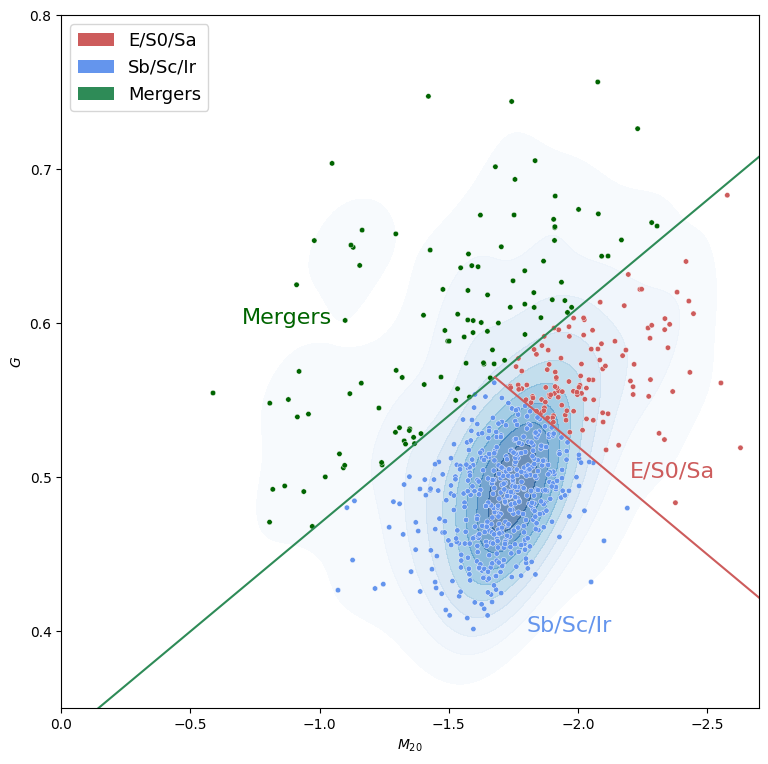

In [5]:
from matplotlib.patches import Patch

ginis = properties['Gini']
m20s = properties['M20']
print(len(ginis), len(m20s))

# Definimos las ecuaciones de las líneas
def line_1(x):
    return -0.14 * x + 0.33

def line_2(x):
    return 0.14 * x + 0.80

# Clasificación basada en la posición relativa
colors = []
mergers_g = []
early_g = []
late_g = []
for gini, m20 in zip(ginis, m20s):
    if gini < line_1(m20) and gini > line_2(m20):  # Encima de ambas líneas (Mergers)
        colors.append('indianred')
        early_g.append(gini)
    elif gini <= line_1(m20) and gini < line_2(m20):  # Debajo de la línea roja (Sb/Sc/Ir)
        colors.append('cornflowerblue')
        late_g.append(gini)
    else:  # Entre las líneas roja y verde (E/S0/Sa)
        colors.append('darkgreen')
        mergers_g.append(gini)

# Generar las líneas y el gráfico
lim_2 = (0.8 - 0.33) / (-0.14 - 0.14)
x_line_1 = np.linspace(-3, 0, 100)
x_line_2 = np.linspace(-3, lim_2, 100)
y_line_1 = line_1(x_line_1)
y_line_2 = line_2(x_line_2)

plt.figure(figsize=(9, 9))

plt.plot(x_line_1, y_line_1, color='seagreen')
plt.plot(x_line_2, y_line_2, color='indianred')
sns.kdeplot(x=m20s, y=ginis, cmap='Blues', alpha=0.6, fill=True)

# Colorear los puntos según su clasificación
sns.scatterplot(x=m20s, y=ginis, c=colors, s=15)

# Crear leyenda personalizada
legend_elements = [
    Patch(facecolor='indianred', label='E/S0/Sa'),
    Patch(facecolor='cornflowerblue', label='Sb/Sc/Ir'),
    Patch(facecolor='seagreen', label='Mergers')
]
plt.legend(handles=legend_elements, fontsize=13, loc='upper left')

plt.xlim(0, -2.7)
plt.ylim(0.35, 0.8)
plt.xlabel(r'$M_{20}$')
plt.ylabel(r'$G$')
#plt.title('Gini - M20 Classification System', fontsize=14)
#plt.legend(fontsize=14)

plt.text(-2.2, 0.5, 'E/S0/Sa', fontsize=16, color='indianred')
plt.text(-1.8, 0.40, 'Sb/Sc/Ir', fontsize=16, color='cornflowerblue')
plt.text(-0.7, 0.6, 'Mergers', fontsize=16, color='darkgreen')

plt.show()

In [6]:
print(f'La cantidad de galaxias Late-Type es: {len(late_g)}, que corresponde a un {round((len(late_g)/len(properties))*100, 2)}%')

print(f'La cantidad de galaxias Early-Type es: {len(early_g)}, que corresponde a un {round((len(early_g)/len(properties))*100, 2)}%')

print(f'La cantidad de galaxias en Mergers es: {len(mergers_g)}, que corresponde a un {round((len(mergers_g)/len(properties))*100, 2)}%')

La cantidad de galaxias Late-Type es: 450, que corresponde a un 66.37%
La cantidad de galaxias Early-Type es: 120, que corresponde a un 17.7%
La cantidad de galaxias en Mergers es: 108, que corresponde a un 15.93%


In [7]:
# Clasificación y creación de la columna 'tipo'
tipo = []
for gini, m20 in zip(properties['Gini'], properties['M20']):
    if gini < line_1(m20) and gini > line_2(m20): 
        tipo.append('Early')
    elif gini <= line_1(m20) and gini < line_2(m20): 
        tipo.append('Late')
    else:  
        tipo.append('Merger')

# Agregar la columna 'tipo' a la tabla original
properties['Tipo'] = Column(tipo, dtype='str')

# Mostrar la tabla para verificar
print(len(properties[properties['Tipo'] == 'Merger']))

108


In [8]:
# Clasificación y creación de la columna 'tipo'
tipo = []
for gini, m20 in zip(properties_cs['Gini'], properties_cs['M20']):
    if gini < line_1(m20) and gini > line_2(m20): 
        tipo.append('Early')
    elif gini <= line_1(m20) and gini < line_2(m20): 
        tipo.append('Late')
    else:  
        tipo.append('Merger')

# Agregar la columna 'tipo' a la tabla original
properties_cs['Tipo'] = Column(tipo, dtype='str')

# Mostrar la tabla para verificar
print(properties_cs)

 GAL          ra                 dec         ...   NUV    nuv_magerr  Tipo 
----- ------------------ ------------------- ... -------- ---------- ------
1065r  35.41580960108751  -7.621241997560796 ... 21.66413  0.1330014   Late
 239r 206.82835229399188  12.402478263113585 ... 18.78526 0.05063036   Late
 770r  133.4657616727374   30.02860744606661 ... 23.84124  0.4393416   Late
 376r   123.647400640168   25.06948458735056 ... 19.33441 0.04816663   Late
  33r  202.6120361443454 -1.5298546681235563 ... 19.63903  0.1308773   Late
 161r  6.097811120137832 -0.5144885273005414 ... 20.02043 0.06175241   Late
 452r 174.10515468235536 -2.9437436934805445 ... 21.91566  0.3841992   Late
 290r  6.833183139101775  -0.963764628334356 ... 19.12872 0.05808195   Late
1163r 144.78908606513895  0.9844753619840728 ... 20.48815 0.05563092   Late
 233r 228.16020761767464   0.960467385071539 ... 19.65258  0.1165294   Late
  ...                ...                 ... ...      ...        ...    ...
 700r 135.50

In [9]:
print((properties[properties['Tipo'] == 'Merger']))

GAL          ra                 dec         radvel ...  Rij   sigmalos  Tipo 
---- ------------------ ------------------- ------ ... ------ -------- ------
650r 330.16832295066064  -42.81858602182859 5000.0 ...     --       -- Merger
889r  12.87242054718038 -23.213493513441747 5000.0 ...     --       -- Merger
599r  4.658733882664886  -35.94581013806873 5000.0 ...     --       -- Merger
353r  69.31891294968393  -46.68419160802532 5000.0 ...     --       -- Merger
847r 178.47638220465217   21.24985967185494 5000.0 ...     --       -- Merger
936r 203.31742466365608    11.0757088000823 5000.0 ...     --       -- Merger
938r 203.32531533034384  11.088201821215334 5000.0 ...     --       -- Merger
270r 165.28360704635455   16.73517676997224 5000.0 ...     --       -- Merger
 76r  57.73091127047771  -38.04190763699464 5000.0 ...     --       -- Merger
800r  238.3782000566084   20.98374857025089 5000.0 ...     --       -- Merger
 ...                ...                 ...    ... ...    ...   

678 678 678


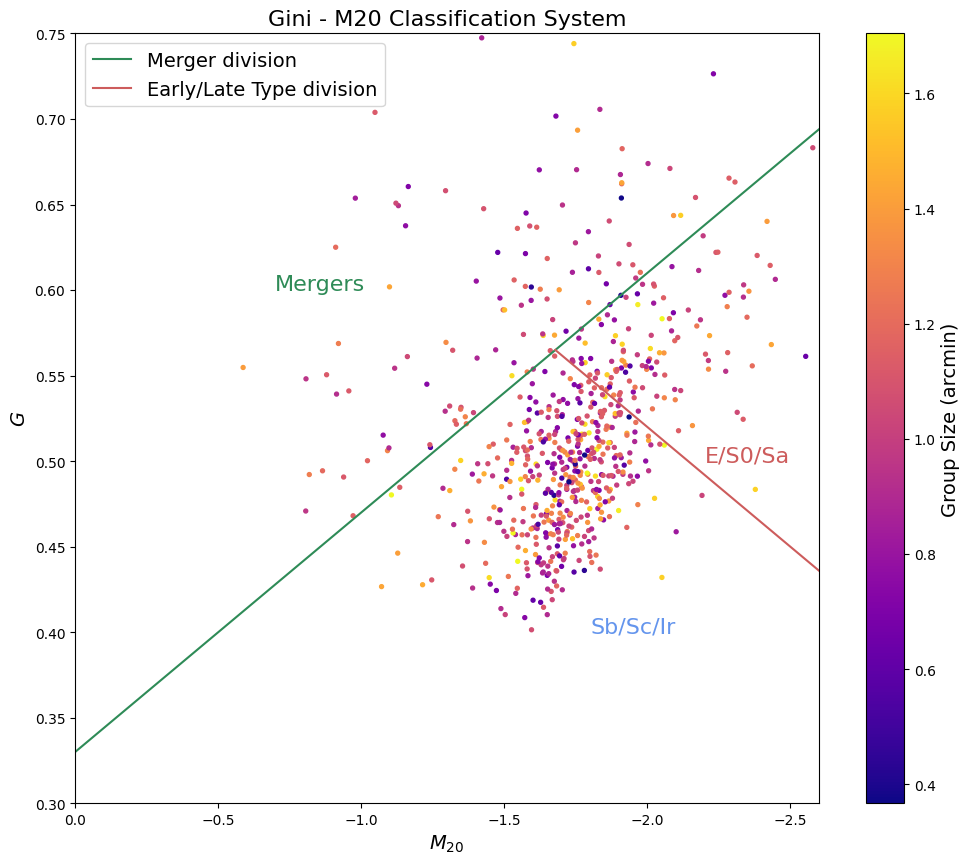

In [10]:
ginis = properties['Gini']
m20s = properties['M20']
rgroups = properties['r_theta']  # Asegúrate de que esta columna exista en 'properties'

print(len(ginis), len(m20s), len(rgroups))

# Definimos las ecuaciones de las líneas
def line_1(x):
    return -0.14 * x + 0.33

def line_2(x):
    return 0.14 * x + 0.80

# Generar las líneas
lim_2 = (0.8 - 0.33) / (-0.14 - 0.14)
x_line_1 = np.linspace(-2.6, 0, 100)
x_line_2 = np.linspace(-2.6, lim_2, 100)
y_line_1 = line_1(x_line_1)
y_line_2 = line_2(x_line_2)

# Crear un mapa de colores normalizado para la barra de color
norm = mcolors.Normalize(vmin=min(rgroups), vmax=max(rgroups))
cmap = cm.plasma  # Puedes cambiar el mapa de colores según prefieras

plt.figure(figsize=(12, 10))

# Dibujar las líneas
plt.plot(x_line_1, y_line_1, color='seagreen', label='Merger division')
plt.plot(x_line_2, y_line_2, color='indianred', label='Early/Late Type division')

# Colorear los puntos según los valores de rgroup
sc = plt.scatter(m20s, ginis, c=rgroups, cmap=cmap, s=8)

# Configurar los límites y etiquetas
plt.xlim(0, -2.6)
plt.ylim(0.3, 0.75)
plt.xlabel(r'$M_{20}$', fontsize=14)
plt.ylabel(r'$G$', fontsize=14)
plt.title('Gini - M20 Classification System', fontsize=16)

# Etiquetas para las regiones
plt.text(-2.2, 0.5, 'E/S0/Sa', fontsize=16, color='indianred')
plt.text(-1.8, 0.40, 'Sb/Sc/Ir', fontsize=16, color='cornflowerblue')
plt.text(-0.7, 0.6, 'Mergers', fontsize=16, color='seagreen')

# Añadir la barra de color
cbar = plt.colorbar(sc)
cbar.set_label('Group Size (arcmin)', fontsize=14)

plt.legend(fontsize=14)
plt.show()


678 678 678


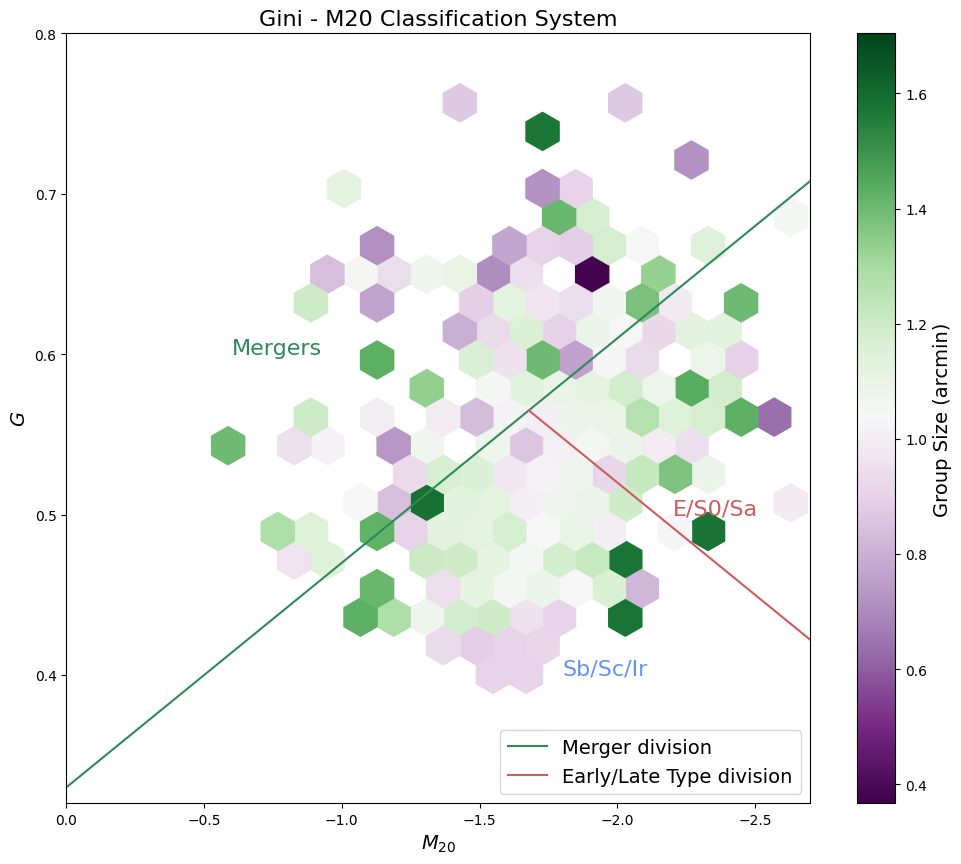

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Variables iniciales
ginis = properties['Gini']
m20s = properties['M20']
rgroups = properties['r_theta']  # Asegúrate de que esta columna exista en 'properties'

print(len(ginis), len(m20s), len(rgroups))

# Definimos las ecuaciones de las líneas
def line_1(x):
    return -0.14 * x + 0.33

def line_2(x):
    return 0.14 * x + 0.80

# Generar las líneas
lim_2 = (0.8 - 0.33) / (-0.14 - 0.14)
x_line_1 = np.linspace(-3, 0, 100)
x_line_2 = np.linspace(-3, lim_2, 100)
y_line_1 = line_1(x_line_1)
y_line_2 = line_2(x_line_2)

# Crear un mapa de colores normalizado para la barra de color
norm = mcolors.Normalize(vmin=min(rgroups), vmax=max(rgroups))
cmap = cm.PRGn  # Puedes cambiar el mapa de colores según prefieras

plt.figure(figsize=(12, 10))

# Dibujar las líneas
plt.plot(x_line_1, y_line_1, color='seagreen', label='Merger division')
plt.plot(x_line_2, y_line_2, color='indianred', label='Early/Late Type division')

# Crear un hexbin plot
hb = plt.hexbin(m20s, ginis, C=rgroups, gridsize=(17, 20), cmap=cmap, reduce_C_function=np.mean, mincnt=1, norm=norm)

# Configurar los límites y etiquetas
plt.xlim(0, -2.7)
plt.ylim(0.32, 0.8)
plt.xlabel(r'$M_{20}$', fontsize=14)
plt.ylabel(r'$G$', fontsize=14)
plt.title('Gini - M20 Classification System', fontsize=16)

# Etiquetas para las regiones
plt.text(-2.2, 0.5, 'E/S0/Sa', fontsize=16, color='indianred')
plt.text(-1.8, 0.40, 'Sb/Sc/Ir', fontsize=16, color='cornflowerblue')
plt.text(-0.6, 0.6, 'Mergers', fontsize=16, color='seagreen')

# Añadir la barra de color
cbar = plt.colorbar(hb)
cbar.set_label('Group Size (arcmin)', fontsize=14)

# Añadir la leyenda
plt.legend(fontsize=14)
plt.show()


In [12]:
def filtrado(archivo):
    grouped = archivo.group_by('Group')

    valid_groups=[]

    for group in grouped.groups:
        if any (group['zmemb'] != 0):
            valid_groups.append(group['Group'][0])
    print(len(valid_groups))
    filtered_table = archivo[np.isin(archivo['Group'], valid_groups)]

    # Crear una función para reemplazar los valores de 'zmemb' que son 0
    def replace_zeros(group):
        non_zero_values = group['zmemb'][group['zmemb'] != 0]
        if len(non_zero_values) > 0:
            replacement_value = non_zero_values[0]
            group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
        return group

    # Aplicar la función a cada grupo y unir los resultados
    result_groups = []
    for group in filtered_table.group_by('Group').groups:
        result_groups.append(replace_zeros(group))

    final_table = vstack(result_groups)
    
    return final_table

In [13]:
properties_z = filtrado(properties)
H_0 = 67.4 #km/s/Mpc
c = 300000
properties_z['Distance (Kpc)'] = ((properties_z['zUV']*c)/H_0)*1000
properties_z['group_size_kpc'] = properties_z['Distance (Kpc)']*(properties_z['r_theta']*2.9e-4)
properties_z = properties_z[~properties_z['group_size_kpc'].mask]
properties_z

149


GAL,ra,dec,radvel,z,mag,r20,r50,r80,flux_c,flux_e,rpetro_c,rpetro_e,rhalf_c,rhalf_e,Gini,M20,F(G_M20),S(G_M20),SN_per_pixel,C,A,S,M,I,D,Ao,As,Ser_A,Ser_R,Ser_n,Ser_xc,Ser_yc,Ser_ellip,Ser_theta,flag_morph,flag_sersic,ima_sc_pix2arc,ima_sc_arc2kpc,psf_arcsec,size_image_phy_kpc,zp_ima,eta,petro_extent_cas,snr,area_min,debleding,area_min_deblend,skybox_x,skybox_y,sky_method,nsigma,npixels,dilate_size,mask_stars,fwhm,threshold,roundlo,roundhi,sharplo,aper_stars,aper_fact,aper_center,aper_ellip,aper_pa,dr,View,area_segmap_pix,area_psf_pix,ratio_segmap_psf,flag_area,flag_area_th,SN_gal,bck,ratio_SN_gal,flag_SN,flag_SN_th,perc_SN_flag,perc_20_SN_gal,perc_50_SN_gal,perc_80_SN_gal,flag_image,flag_bck,flag_object,flag_statmorph,Group,brickid,brickname,objid,type,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g,mag_r,mag_i,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,Gal,zmemb,gmemb,FUV,NUV,zUV,nUV_2,ngal,nz,mz,r_theta,Rij,sigmalos,Tipo,Distance (Kpc),group_size_kpc
str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,str6,float64,float64
455r,0.3586687708259794,13.112666328585568,5000.0,0.0166666666666666,--,12.428152225725054,27.213320250729097,47.90665641622371,1444.7871609057029,1446.461153945279,60.065995545802224,79.24783805754062,28.113330666949803,36.23545602895981,0.5499606512825843,-1.52672539813619,-0.1796740752428278,0.0052462144288279,0.296438604593277,2.9299464841709275,0.3396884352518462,0.0420462391365464,0.0082801449025357,0.0519778096837577,0.1434553512614585,0.3631832776738919,0.2581125886889872,0.2060491244597581,29.4791525034512,0.8417978532078338,320.760538221273,322.9492269812382,0.3504456189432606,0.9185011297560866,2.0,0.0,0.27,0.3462954865095246,1.2880095,30.0,22.5,0.2,1.5,2.5,5.0,1.0,5.0,5.0,5.0,masking_sources,2.0,5.0,11.0,1.0,3.0,10.0,-0.5,0.5,0.2,5.0,0.5,10.0,0.0,0.0,10.0,Face-on,15339.0,17.9,858.2,0.0,3.0,0.04076,0.0041499999351799,9.8,0.0,3.0,50.0,4.5,9.8,28.8,0.0,0.0,0.0,0.0,2,404689,0003p130,4495,DUP,0.08077177,0.0,0.0,0.0,0.0,1.5825707,1.2880095,0.0,1.4925475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,inf,inf,inf,inf,inf,inf,--,--,--,--,3,0.017532,--,17.1312,16.6332,0.017899,4,4,3,3,1.611,32.94,193.85,Merger,79669.13946587537,37.22062526706231
456r,0.3333172212276458,13.111234768521603,5000.0,0.0166666666666666,--,23.58584306536231,43.72019836028031,71.38313847179413,4241.148704994138,4216.078735737498,92.13100270672284,113.41102836370182,44.25910057431293,58.783671747391296,0.5216426671789602,-1.782022830433469,-0.1429269759737526,-0.0582749329230815,0.3882557153701782,2.4047211697905646,-0.0006203751766749,0.0519848101467841,0.0398613518197573,0.4706542105941748,0.0512267961473403,0.2476000596535163,0.1437768325795533,0.3763020484093843,48.25674375579878,0.6862184169925561,318.4709334528395,319.97240333780525,0.4576303982529207,2.971524449553313,1.0,0.0,0.27,0.3462954865095246,1.2880095,30.0,22.5,0.2,1.5,2.5,5.0,1.0,5.0,5.0,5.0,maskin

495 495 495


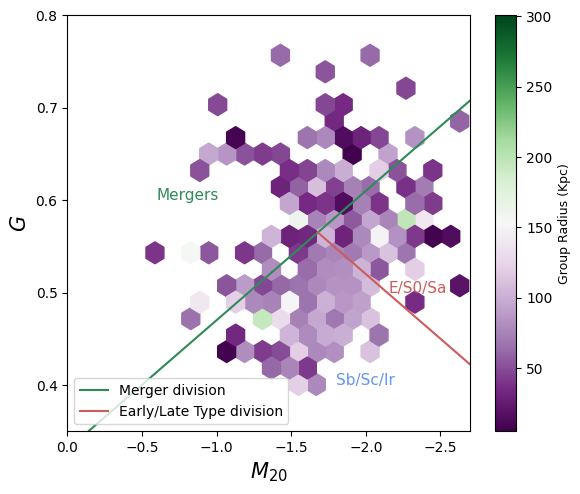

In [14]:
# Variables iniciales
ginis = properties_z['Gini']
m20s = properties_z['M20']
rgroups = properties_z['group_size_kpc']  # Asegúrate de que esta columna exista en 'properties'

print(len(ginis), len(m20s), len(rgroups))

# Definimos las ecuaciones de las líneas
def line_1(x):
    return -0.14 * x + 0.33

def line_2(x):
    return 0.14 * x + 0.80

# Generar las líneas
lim_2 = (0.8 - 0.33) / (-0.14 - 0.14)
x_line_1 = np.linspace(-3, 0, 100)
x_line_2 = np.linspace(-3, lim_2, 100)
y_line_1 = line_1(x_line_1)
y_line_2 = line_2(x_line_2)

# Crear un mapa de colores normalizado para la barra de color
norm = mcolors.Normalize(vmin=min(rgroups), vmax=max(rgroups))
cmap = cm.PRGn  # Puedes cambiar el mapa de colores según prefieras

plt.figure(figsize=(6.5, 5.4))

# Dibujar las líneas
plt.plot(x_line_1, y_line_1, color='seagreen', label='Merger division')
plt.plot(x_line_2, y_line_2, color='indianred', label='Early/Late Type division')

# Crear un hexbin plot
hb = plt.hexbin(m20s, ginis, C=rgroups, gridsize=(17, 20), cmap=cmap, reduce_C_function=np.mean, mincnt=1, norm=norm)

# Configurar los límites y etiquetas
plt.xlim(0, -2.7)
plt.ylim(0.35, 0.8)
plt.xlabel(r'$M_{20}$', fontsize=15)
plt.ylabel(r'$G$', fontsize=15)
#plt.title('Gini - M20 Classification System', fontsize=16)

# Etiquetas para las regiones
plt.text(-2.15, 0.5, 'E/S0/Sa', fontsize=11, color='indianred')
plt.text(-1.8, 0.40, 'Sb/Sc/Ir', fontsize=11, color='cornflowerblue')
plt.text(-0.6, 0.6, 'Mergers', fontsize=11, color='seagreen')

# Añadir la barra de color
cbar = plt.colorbar(hb)
cbar.set_label('Group Radius (Kpc)', fontsize=9)

# Añadir la leyenda
plt.legend(fontsize=10, loc='lower left')
plt.show()

In [15]:
def bootstrap_median_error(data, n_bootstrap=1000, ci=68):
    """
    Calcula el error de la mediana usando bootstrapping.

    Parámetros:
    - data: array-like, los datos de entrada.
    - n_bootstrap: int, número de resamples (1000 por defecto).
    - ci: int, intervalo de confianza deseado (en porcentaje, 68 o 95 por ejemplo).

    Retorna:
    - mediana: la mediana calculada de los datos originales.
    - error_low: desviación negativa respecto a la mediana.
    - error_high: desviación positiva respecto a la mediana.
    """
    medians = []
    for _ in range(n_bootstrap):
        resample = np.random.choice(data, size=len(data), replace=True)
        medians.append(np.median(resample))
    
    medians = np.array(medians)
    median = np.median(data)
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    error_low = median - np.percentile(medians, lower_percentile)
    error_high = np.percentile(medians, upper_percentile) - median
    
    return median, error_low, error_high
# Definimos las ecuaciones de las líneas
def line_1(x):
    return -0.14 * x + 0.33

def line_2(x):
    return 0.14 * x + 0.80

Mergers Median: 51.47 (+7.53 / -2.79)
Late Median: 74.16 (+2.44 / -3.47)
Early Median: 62.48 (+3.59 / -3.48)


/home/seba/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

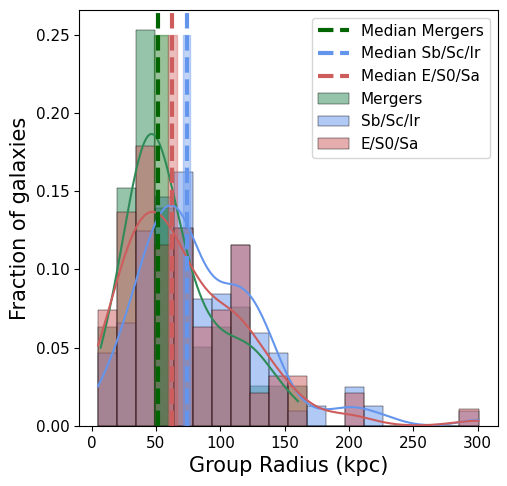

Median Difference (Late - Mergers): 22.691500059347177


In [16]:
# Datos
size_mergers = properties_z['group_size_kpc'][properties_z['Tipo'] == 'Merger']
size_late = properties_z['group_size_kpc'][properties_z['Tipo'] == 'Late']
size_early = properties_z['group_size_kpc'][properties_z['Tipo'] == 'Early']
# Crear bins
bin_edges = np.linspace(min(size_mergers.min(), size_late.min()), 
                        max(size_mergers.max(), size_late.max()), 
                        21)

# Ejemplo de uso para tus distribuciones
median_mergers, err_low_mergers, err_high_mergers = bootstrap_median_error(size_mergers)
median_late, err_low_late, err_high_late = bootstrap_median_error(size_late)
median_early, err_low_early, err_high_early = bootstrap_median_error(size_early)

# Imprimir resultados
print(f"Mergers Median: {median_mergers:.2f} (+{err_high_mergers:.2f} / -{err_low_mergers:.2f})")
print(f"Late Median: {median_late:.2f} (+{err_high_late:.2f} / -{err_low_late:.2f})")
print(f"Early Median: {median_early:.2f} (+{err_high_early:.2f} / -{err_low_early:.2f})")


# Crear la figura
plt.figure(figsize=(5.4, 5.4))

# Histogramas
sns.histplot(size_mergers, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='seagreen', label='Mergers', edgecolor='black', linewidth=0.3)
sns.histplot(size_late, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='cornflowerblue', label='Sb/Sc/Ir', edgecolor='black', linewidth=0.3)
sns.histplot(size_early, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='indianred', label='E/S0/Sa', edgecolor='black', linewidth=0.3)

plt.axvline(median_mergers, color='darkgreen', linestyle='--', linewidth=3, label='Median Mergers')
plt.fill_betweenx(y=[0, 0.25], x1=median_mergers - err_low_mergers, x2=median_mergers + err_high_mergers, 
                  color='darkgreen', alpha=0.4)
plt.axvline(median_late, color='cornflowerblue', linestyle='--', linewidth=3, label='Median Sb/Sc/Ir')
plt.fill_betweenx(y=[0, 0.25], x1=median_late - err_low_late, x2=median_late + err_high_late, 
                  color='cornflowerblue', alpha=0.4)
plt.axvline(median_early, color='indianred', linestyle='--', linewidth=3, label='Median E/S0/Sa')
plt.fill_betweenx(y=[0, 0.25], x1=median_early - err_low_early, x2=median_early + err_high_early, 
                  color='indianred', alpha=0.4)

# Etiquetas y título
plt.xlabel('Group Radius (kpc)', fontsize=15)
plt.ylabel('Fraction of galaxies', fontsize=15)
plt.xticks(size=11)
plt.yticks(size=11)

# Leyenda
plt.legend(fontsize=11)

# Mostrar gráfico
plt.show()

print(f"Median Difference (Late - Mergers): {median_late - median_mergers}")

1107 1107


/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


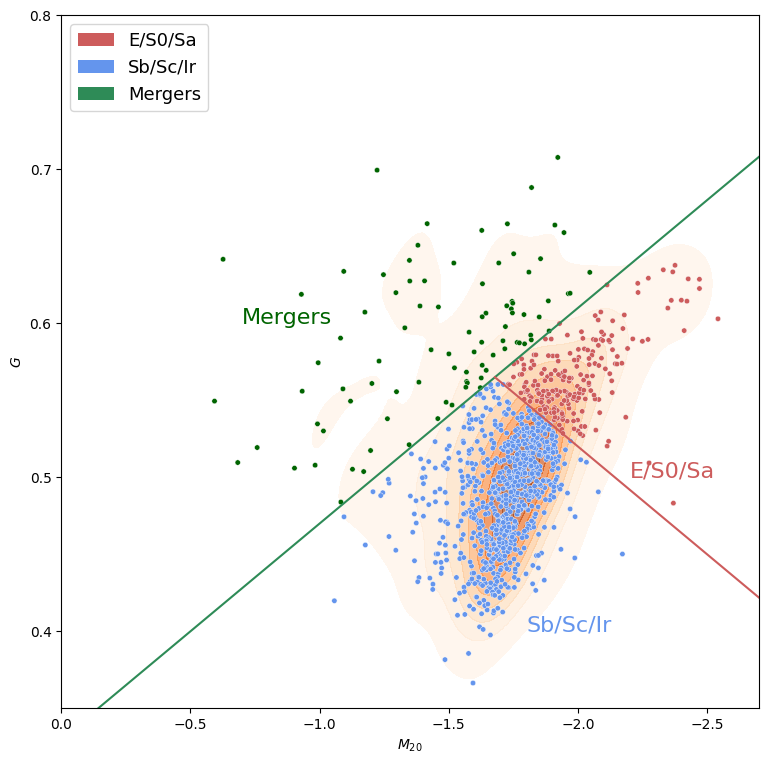

In [17]:
ginis_cs = properties_cs['Gini']
m20s_cs = properties_cs['M20']
print(len(ginis_cs), len(m20s_cs))


# Clasificación basada en la posición relativa
colors = []
mergers = []
early = []
late = []
for gini, m20 in zip(ginis_cs, m20s_cs):
    if gini < line_1(m20) and gini > line_2(m20):  
        colors.append('indianred')
        early.append(gini)
    elif gini <= line_1(m20) and gini < line_2(m20):  
        colors.append('cornflowerblue')
        late.append(gini)
    else:  
        colors.append('darkgreen')
        mergers.append(gini)

# Generar las líneas y el gráfico
lim_2 = (0.8 - 0.33) / (-0.14 - 0.14)
x_line_1 = np.linspace(-3, 0, 100)
x_line_2 = np.linspace(-3, lim_2, 100)
y_line_1 = line_1(x_line_1)
y_line_2 = line_2(x_line_2)

plt.figure(figsize=(9, 9))

plt.plot(x_line_1, y_line_1, color='seagreen')
plt.plot(x_line_2, y_line_2, color='indianred')
sns.kdeplot(x=m20s_cs, y=ginis_cs, cmap='Oranges', alpha = 0.6, fill=True)

# Colorear los puntos según su clasificación
sns.scatterplot(x=m20s_cs, y=ginis_cs, c=colors, label='Field Galaxies', s=15)

# Crear leyenda personalizada
legend_elements = [
    Patch(facecolor='indianred', label='E/S0/Sa'),
    Patch(facecolor='cornflowerblue', label='Sb/Sc/Ir'),
    Patch(facecolor='seagreen', label='Mergers')
]
plt.legend(handles=legend_elements, fontsize=13, loc='upper left')

plt.xlim(0, -2.7)
plt.ylim(0.35, 0.8)
plt.xlabel(r'$M_{20}$')
plt.ylabel(r'$G$')

plt.text(-2.2, 0.5, 'E/S0/Sa', fontsize=16, color='indianred')
plt.text(-1.8, 0.40, 'Sb/Sc/Ir', fontsize=16, color='cornflowerblue')
plt.text(-0.7, 0.6, 'Mergers', fontsize=16, color='darkgreen')

plt.show()

In [18]:
print(f'La cantidad de galaxias Late-Type es: {len(late)}, que corresponde a un {round((len(late)/len(properties_cs))*100, 2)}%')

print(f'La cantidad de galaxias Early-Type es: {len(early)}, que corresponde a un {round((len(early)/len(properties_cs))*100, 2)}%')

print(f'La cantidad de galaxias en Mergers es: {len(mergers)}, que corresponde a un {round((len(mergers)/len(properties_cs))*100, 2)}%')

La cantidad de galaxias Late-Type es: 809, que corresponde a un 73.08%
La cantidad de galaxias Early-Type es: 208, que corresponde a un 18.79%
La cantidad de galaxias en Mergers es: 90, que corresponde a un 8.13%


In [19]:
early_type_sfcg = properties[properties['Tipo'] == 'Early']
late_type_sfcg = properties[properties['Tipo'] == 'Late']
merger_type_sfcg = properties[properties['Tipo'] == 'Merger']

early_type_cs = properties_cs[properties_cs['Tipo'] == 'Early']
late_type_cs = properties_cs[properties_cs['Tipo'] == 'Late']
merger_type_cs = properties_cs[properties_cs['Tipo'] == 'Merger']

[[17.69911504]
 [66.37168142]
 [15.92920354]] [[18.78952123]
 [73.08039747]
 [ 8.1300813 ]]
[[120]
 [450]
 [108]] [[208]
 [809]
 [ 90]]


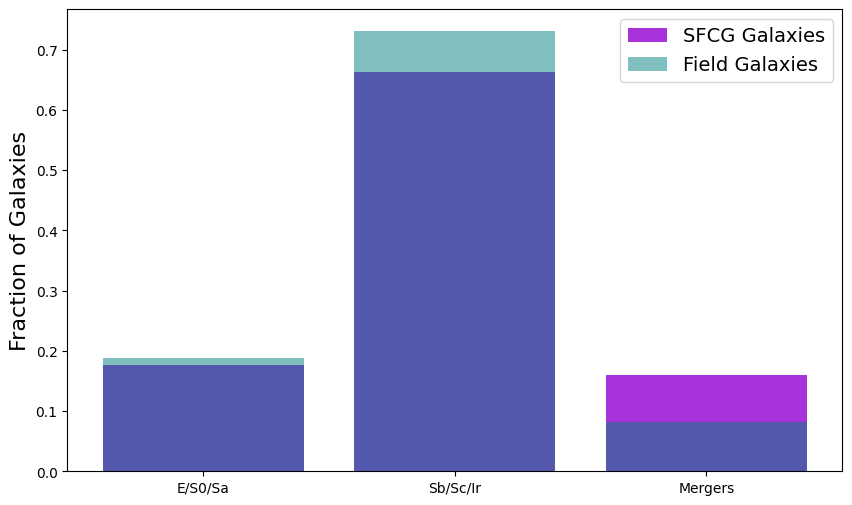

In [20]:
tabla_names = ['E/S0/Sa', 'Sb/Sc/Ir', 'Mergers']

tablas_sfcg = [early_type_sfcg, late_type_sfcg, merger_type_sfcg]
tablas_cs = [early_type_cs, late_type_cs, merger_type_cs]

# Crear una lista para almacenar las fracciones para cada tabla
fractions = []
amount = []
for tabla in tablas_sfcg:
    sf_galaxies = len(tabla)
    amount.append([sf_galaxies])
    # Calcular la fracción respecto al total
    sf_fraction = sf_galaxies / len(properties)
    
    # Añadir las fracciones a la lista
    fractions.append([sf_fraction])

fractions_cs = []
amount_cs = [] 
for tabla_cs in tablas_cs:
    field_galaxies = len(tabla_cs)
    amount_cs.append([field_galaxies])
    field_fraction = field_galaxies / len(properties_cs)
    
    # Añadir las fracciones a la lista
    fractions_cs.append([field_fraction])

# Convertir los resultados en un array de numpy
fractions = np.array(fractions)
fractions_cs = np.array(fractions_cs)
amount = np.array(amount)
amount_cs = np.array(amount_cs)
print(fractions*100, fractions_cs*100)
print(amount, amount_cs)
# Crear el histograma apilado
fig, ax = plt.subplots(figsize=(10, 6))

# Definir las posiciones de los bins (uno para cada tabla)
bins = np.arange(len(tabla_names))

bar1 = ax.bar(bins, fractions[:, 0], alpha = 0.8, label='SFCG Galaxies', color='darkviolet')
bar2 = ax.bar(bins, fractions_cs[:, 0], alpha = 0.5, label='Field Galaxies', color='teal')

ax.set_xticks(bins)
ax.set_xticklabels(tabla_names)
#ax.set_xlabel('Galaxy Type', fontsize=16)
ax.set_ylabel('Fraction of Galaxies', fontsize=16)
#ax.set_title('Fraction of Galaxy Types', fontsize=16)
ax.legend(fontsize=14)

plt.show()

/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/seba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

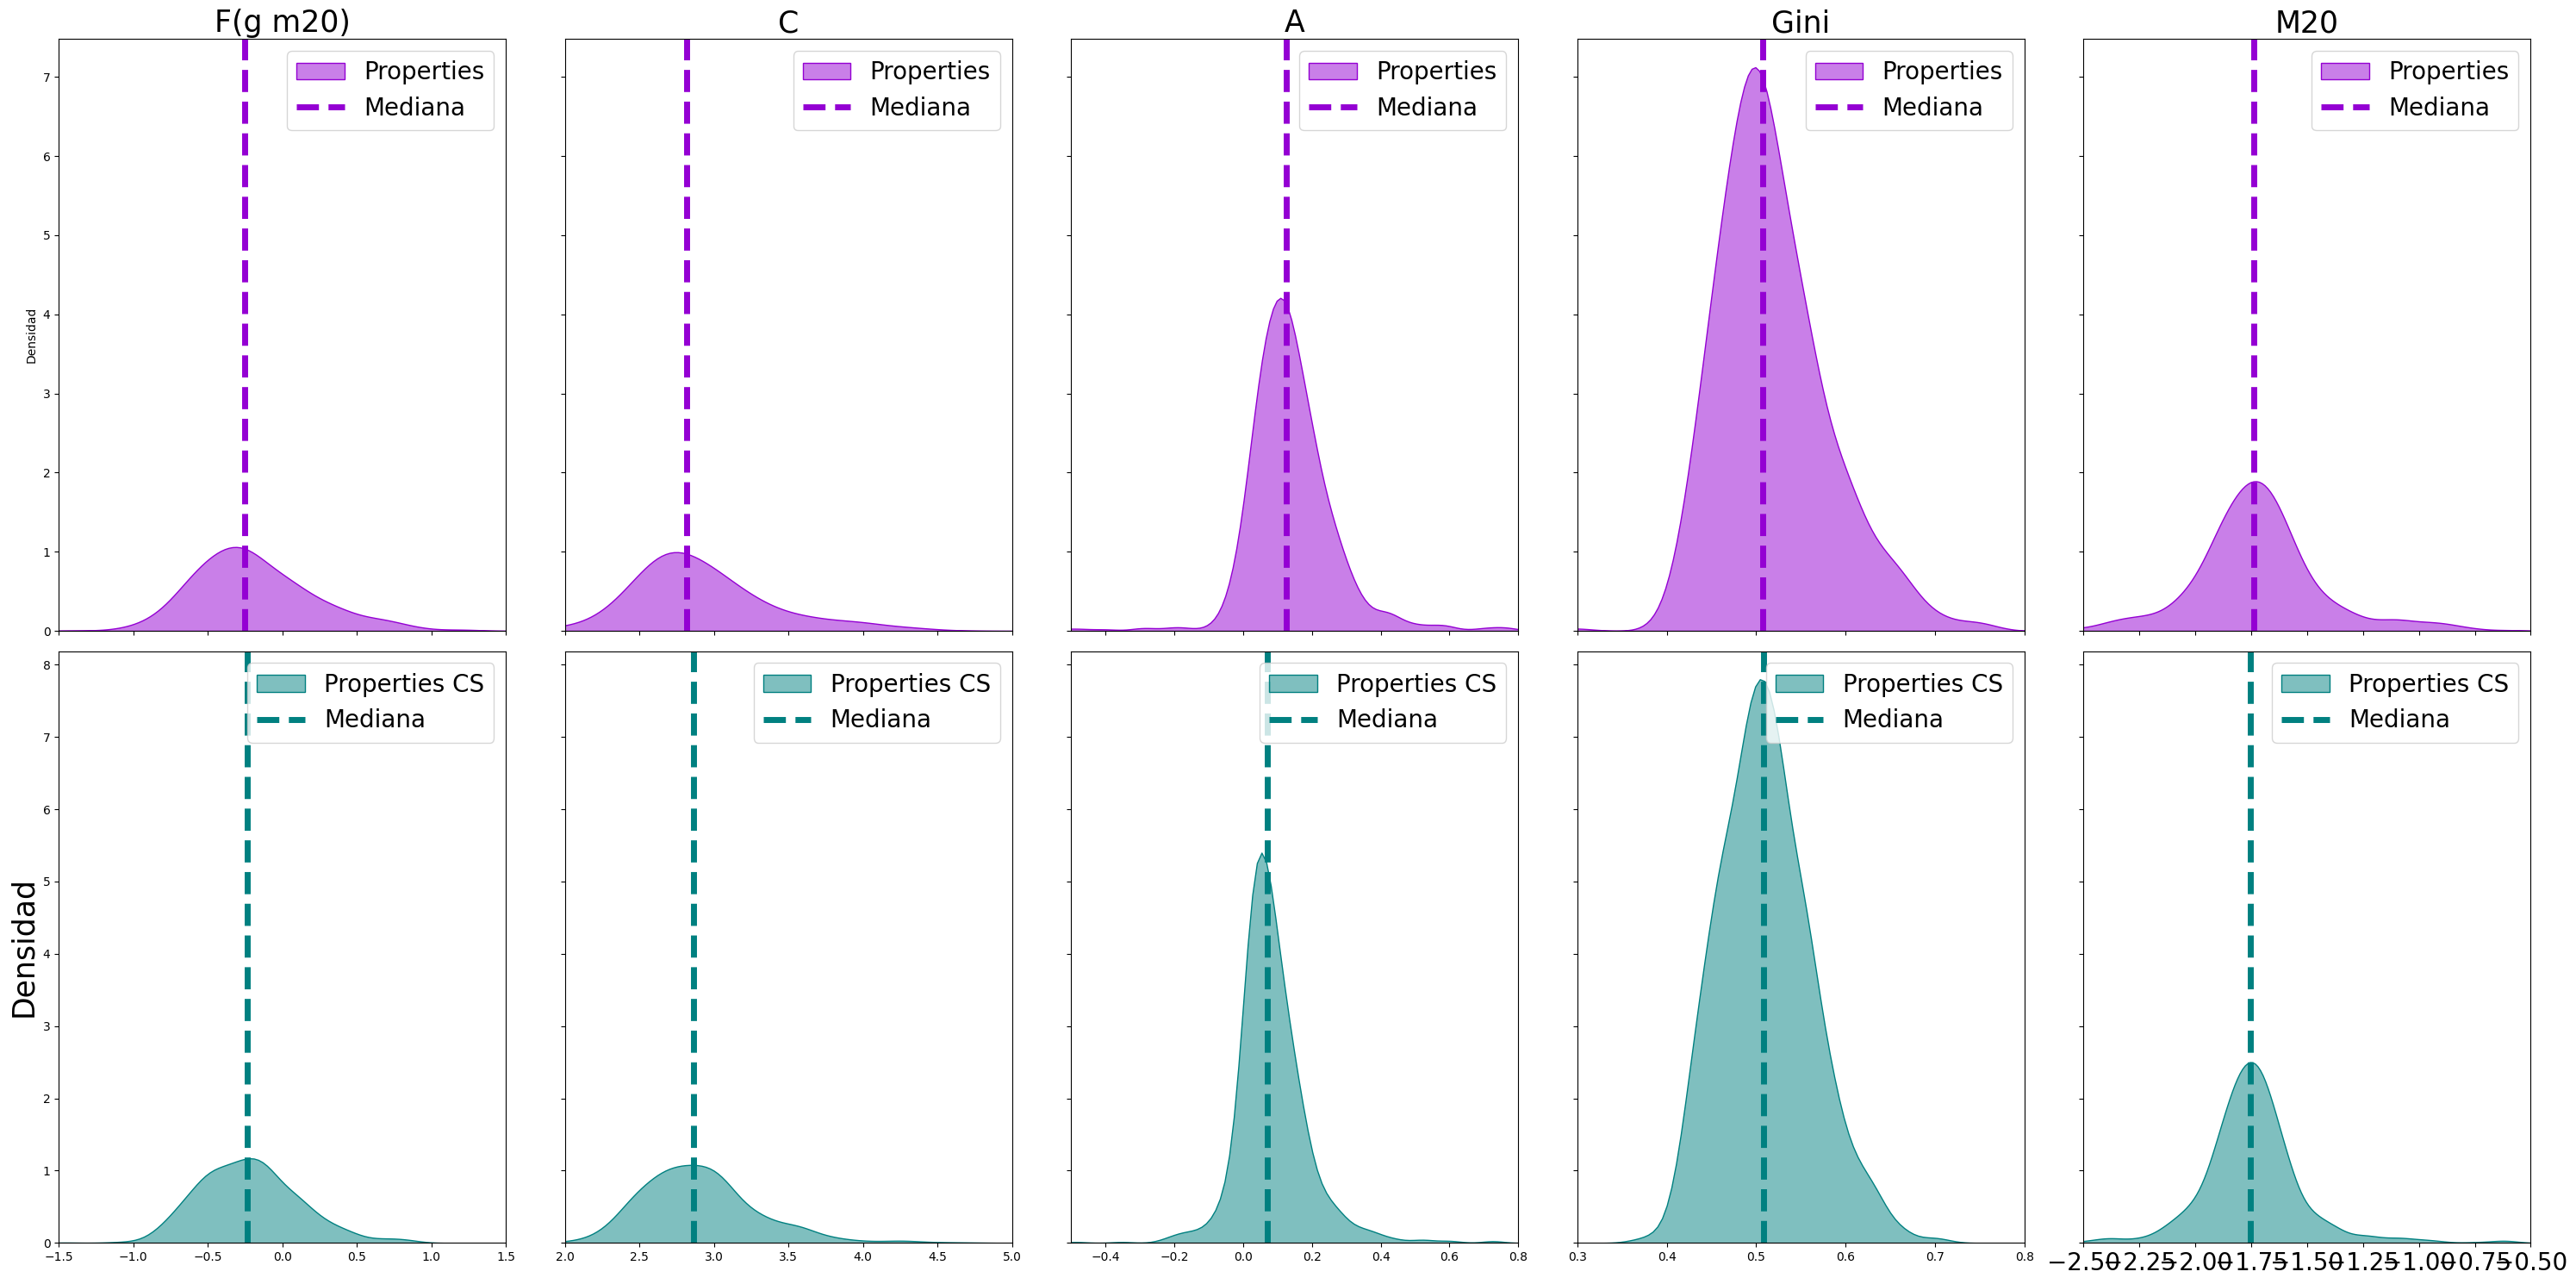

In [21]:
# Lista de parámetros para graficar
parameters = ["F(G_M20)", "C", "A", "Gini", "M20"]
# Definir límites personalizados para cada parámetro
x_limits = {
    "F(G_M20)": [-1.5, 1.5],
    "C": [2.0, 5],
    "A": [-0.5, 0.8],
    "Gini": [0.3, 0.8],
    "M20": [-2.5, -0.5]
}
# Crear subplots con dos filas (una para cada dataset) y múltiples columnas
n_params = len(parameters)
fig, axes = plt.subplots(2, n_params, figsize=(30, 15), sharey='row', sharex='col')

for i, param in enumerate(parameters):
    # Fila 0: Dataset properties
    sns.kdeplot(properties[param], ax=axes[0, i], color="darkviolet", alpha=0.5, fill = True, label="Properties", common_norm=True)
    median_properties = np.median(properties[param])
    axes[0, i].axvline(median_properties, color="darkviolet", linestyle="--", linewidth=5, label="Mediana")
    axes[0, i].set_title(param.replace("_", " ").capitalize(), fontsize=25)
    axes[0, i].set_ylabel("Densidad")
    axes[0, i].legend(fontsize=20)
    
    # Aplicar límites del eje x
    if param in x_limits:
        axes[0, i].set_xlim(x_limits[param])

    # Fila 1: Dataset properties_cs
    sns.kdeplot(properties_cs[param], ax=axes[1, i], color="teal", alpha=0.5, fill=True, label="Properties CS", common_norm=True)
    median_properties_cs = np.median(properties_cs[param])
    axes[1, i].axvline(median_properties_cs, color="teal", linestyle="--", linewidth=5, label="Mediana")
    axes[1, i].set_ylabel("Densidad", fontsize=25)
    axes[1, i].legend(fontsize=20)
    
    if param in x_limits:
        axes[1, i].set_xlim(x_limits[param])

# Ajustar diseño de subplots
plt.xticks(size=20)
plt.yticks(size=20)
plt.tight_layout()
plt.show()

In [22]:
decals_raw = Table.read('amlb_decals_for_regions.csv', format='ascii')
decals = decals_raw[decals_raw['type'] != 'PSF']
filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    decals['n_' + filtro] = pd.to_numeric(decals['n_' + filtro], errors='coerce')
    decals['RE_' +filtro] = pd.to_numeric(decals['RE_' + filtro], errors = 'coerce')
    decals['e_n_' + filtro] = pd.to_numeric(decals['e_n_' + filtro], errors='coerce')
    decals['e_RE_' +filtro] = pd.to_numeric(decals['e_RE_' + filtro], errors = 'coerce')

# Clasificación y creación de la columna 'tipo'
tipo = []
for gini, m20 in zip(decals['Gini'], decals['M20']):
    if gini < line_1(m20) and gini > line_2(m20): 
        tipo.append('Early')
    elif gini <= line_1(m20) and gini < line_2(m20): 
        tipo.append('Late')
    else:  
        tipo.append('Merger')

# Agregar la columna 'tipo' a la tabla original
decals['Tipo'] = Column(tipo, dtype='str')

In [23]:
sfr_decals = Table.read('sfr_decals_k_corrected_asmlb.csv', format='csv')

# Clasificación y creación de la columna 'tipo'
tipo = []
for gini, m20 in zip(sfr_decals['Gini'], sfr_decals['M20']):
    if gini < line_1(m20) and gini > line_2(m20): 
        tipo.append('Early')
    elif gini <= line_1(m20) and gini < line_2(m20): 
        tipo.append('Late')
    else:  
        tipo.append('Merger')

# Agregar la columna 'tipo' a la tabla original
sfr_decals['Tipo'] = Column(tipo, dtype='str')

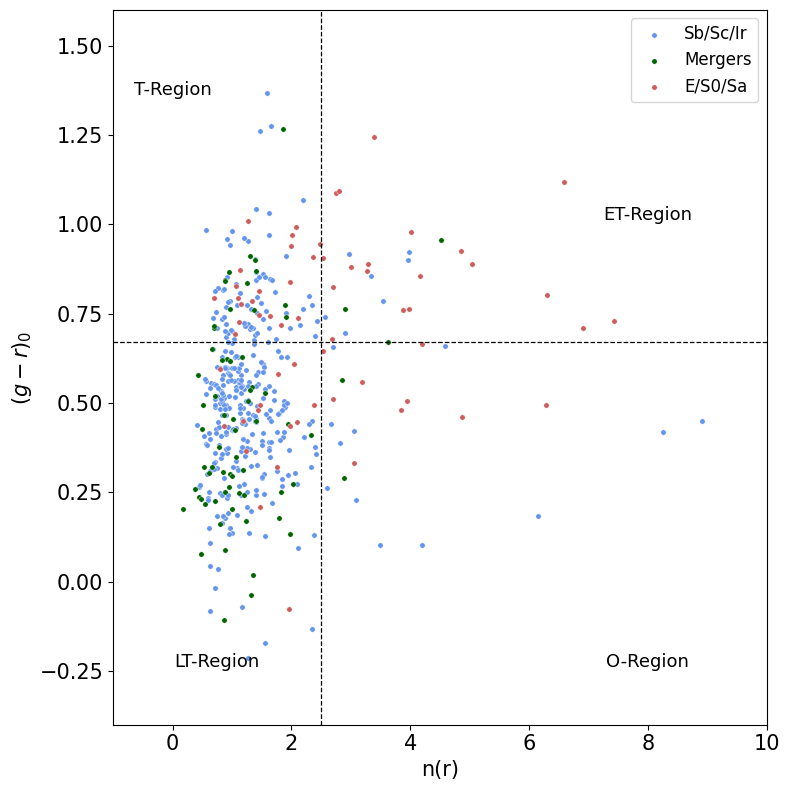

95


In [24]:
decals_no_zero = sfr_decals[sfr_decals['n_r']!=0.0]
g_r_decals = decals_no_zero['m_g_corrected'] - decals_no_zero['m_r_corrected']
n_r = decals_no_zero['n_r']
ginis = decals_no_zero['Gini']
m20s = decals_no_zero['M20']

mask_merger = decals_no_zero['Tipo'] == 'Merger'
mask_late = decals_no_zero['Tipo'] == 'Late'
mask_early = decals_no_zero['Tipo'] == 'Early'


# Crear el gráfico de (g-r) vs. n(r)
plt.figure(figsize=(8, 8))

# Fondo KDEplot del diagrama de densidad
#sns.kdeplot(x=n_r, y=g_r_decals, cmap='Blues', alpha=0.6, fill=True, cbar=True)

# Añadir galaxias clasificadas como late, merger y early
sns.scatterplot(x=decals_no_zero['n_r'][mask_late], y=g_r_decals[mask_late], c='cornflowerblue', label='Sb/Sc/Ir', s=15)
sns.scatterplot(x=decals_no_zero['n_r'][mask_merger], y=g_r_decals[mask_merger], c='darkgreen', label='Mergers', s=15)
sns.scatterplot(x=decals_no_zero['n_r'][mask_early], y=g_r_decals[mask_early], c='indianred', label='E/S0/Sa', s=15)

# Personalización del gráfico
plt.ylim(-0.4, 1.6)
plt.xlim(-1, 10)  # Ajustar según los datos reales de n(r)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('n(r)', size=15)
plt.ylabel('$(g-r)_{0}$', size=15)
plt.axhline(y=0.67, color='black', linestyle='--', linewidth=0.9)  # Línea horizontal
plt.axvline(x=2.5, color='black', linestyle='--', linewidth=0.9)  # Línea vertical

# Añadir texto para las regiones
plt.text(0, 1.35, 'T-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(0.75, -0.25, 'LT-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8, 1, 'ET-Region', fontsize=13, ha='center', va='bottom', color='black')
plt.text(8, -0.25, 'O-Region', fontsize=13, ha='center', va='bottom', color='black')

# Añadir la leyenda
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()

# Mostrar el gráfico
plt.show()
print(len(decals_no_zero['n_r'][mask_early]))

In [25]:
x_valid = n_r[mask_late]
y_valid = g_r_decals[mask_late]

## Filtra valores válidos
#valid_mask = ~np.isnan(x_valid) & ~np.isnan(y_valid) & ~np.isinf(x_valid) & ~np.isinf(y_valid)
#x_valid = x_valid[valid_mask]
#y_valid = y_valid[valid_mask]

late_type_sfcg = np.sum([(y_valid <= 0.67) & (x_valid <= 2.5)])
transition_sfcg = np.sum([(y_valid > 0.67) & (x_valid <= 2.5)])
early_type_sfcg = np.sum([(y_valid >= 0.67) & (x_valid > 2.5)])
other_sfcg = np.sum([(y_valid < 0.67) & (x_valid > 2.5)])
print(late_type_sfcg/len(x_valid), transition_sfcg/len(x_valid), early_type_sfcg/len(x_valid), other_sfcg/len(x_valid))
print(len(x_valid), late_type_sfcg, transition_sfcg, early_type_sfcg, other_sfcg)

0.7240437158469946 0.20765027322404372 0.02185792349726776 0.04644808743169399
366 265 76 8 17


In [26]:
H_0 = 67.4 #km/s/Mpc
c = 300000
sfr_decals['Distance (Mpc)'] = (sfr_decals['zmemb']*c)/H_0
sfr_decals['M_i'] = sfr_decals['m_i_corrected'] - 5*np.log10(sfr_decals['Distance (Mpc)']*1000000) + 5 + 1.592*sfr_decals['ebv']
sfr_decals['stellar_mass_phot_i'] = (1.15 + 0.7*(sfr_decals['m_g_corrected'] - sfr_decals['m_i_corrected']) - 0.4*sfr_decals['M_i'])
sfr_decals['log_sSFR'] = sfr_decals['logSFR_NUV'] - sfr_decals['stellar_mass_phot_i']

mascara = [
    isinstance(val1, float) and isinstance(val2, float) 
    for val1, val2 in zip(sfr_decals['logSFR_NUV'], sfr_decals['stellar_mass_phot_i'])
]

# Filtrar la tabla usando la máscara
sfr_decals = sfr_decals[mascara]
sfr_decals = sfr_decals[sfr_decals['log_sSFR'] > -50]
sfr_decals = sfr_decals[(sfr_decals['A'] != 100) & (sfr_decals['A'] > 0)]

sfr_decals['RE_g'] = sfr_decals['RE_g']*0.262
sfr_decals['RE_r'] = sfr_decals['RE_r']*0.262
sfr_decals['e_RE_r'] = sfr_decals['e_RE_r']*0.262
sfr_decals['RE_i'] = sfr_decals['RE_i']*0.262
sfr_decals['RE_z'] = sfr_decals['RE_z']*0.262
sfr_decals['RE_g(kpc)'] = (sfr_decals['RE_g']*sfr_decals['Distance (Mpc)'])/206.265
sfr_decals['RE_r(kpc)'] = (sfr_decals['RE_r']*sfr_decals['Distance (Mpc)'])/206.265
sfr_decals['e_RE_r(kpc)'] = (sfr_decals['e_RE_r']*sfr_decals['Distance (Mpc)'])/206.265
sfr_decals['RE_i(kpc)'] = (sfr_decals['RE_i']*sfr_decals['Distance (Mpc)'])/206.265
sfr_decals['RE_z(kpc)'] = (sfr_decals['RE_z']*sfr_decals['Distance (Mpc)'])/206.265

In [27]:
sfr_cs = Table.read('sfr_cs_k_corrected_asmlb_2.csv', format='csv')

# Crear una máscara para detectar valores válidos (no NaN y no Inf)
mascara = ~np.isnan(sfr_cs['logSFR_NUV']) & np.isfinite(sfr_cs['logSFR_NUV'])

# Aplicar la máscara a la tabla
sfr_cs = sfr_cs[mascara]

# Clasificación y creación de la columna 'tipo'
tipo = []
for gini, m20 in zip(sfr_cs['Gini'], sfr_cs['M20']):
    if gini < line_1(m20) and gini > line_2(m20): 
        tipo.append('Early')
    elif gini <= line_1(m20) and gini < line_2(m20): 
        tipo.append('Late')
    else:  
        tipo.append('Merger')

# Agregar la columna 'tipo' a la tabla original
sfr_cs['Tipo'] = Column(tipo, dtype='str')
H_0 = 67.4 #km/s/Mpc
c = 300000
sfr_cs['Distance (Mpc)'] = (sfr_cs['zmemb']*c)/H_0
sfr_cs['M_i'] = sfr_cs['m_i_corrected'] - 5*np.log10(sfr_cs['Distance (Mpc)']*1000000) + 5 + 1.592*sfr_cs['ebv']
sfr_cs['stellar_mass_phot_i'] = (1.15 + 0.7*(sfr_cs['m_g_corrected'] - sfr_cs['m_i_corrected']) - 0.4*sfr_cs['M_i'])
sfr_cs['log_sSFR'] = sfr_cs['logSFR_NUV'] - sfr_cs['stellar_mass_phot_i']

mascara = [
    isinstance(val1, float) and isinstance(val2, float) 
    for val1, val2 in zip(sfr_cs['logSFR_NUV'], sfr_cs['stellar_mass_phot_i'])
]

# Filtrar la tabla usando la máscara
sfr_cs = sfr_cs[mascara]
sfr_cs = sfr_cs[(sfr_cs['A'] != 100) & (sfr_cs['A'] > 0)]

filtros = ['g', 'r', 'i', 'z']

for filtro in filtros:        
    sfr_cs['n_' + filtro] = pd.to_numeric(sfr_cs['n_' + filtro], errors='coerce')
    sfr_cs['RE_' +filtro] = pd.to_numeric(sfr_cs['RE_' + filtro], errors = 'coerce')
    sfr_cs['e_n_' + filtro] = pd.to_numeric(sfr_cs['e_n_' + filtro], errors='coerce')
    sfr_cs['e_RE_' +filtro] = pd.to_numeric(sfr_cs['e_RE_' + filtro], errors = 'coerce')

sfr_cs['RE_g'] = sfr_cs['RE_g']*0.262
sfr_cs['RE_r'] = sfr_cs['RE_r']*0.262
sfr_cs['e_RE_r'] = sfr_cs['e_RE_r']*0.262
sfr_cs['RE_i'] = sfr_cs['RE_i']*0.262
sfr_cs['RE_z'] = sfr_cs['RE_z']*0.262
sfr_cs['RE_g(kpc)'] = (sfr_cs['RE_g']*sfr_cs['Distance (Mpc)'])/206.265
sfr_cs['RE_r(kpc)'] = (sfr_cs['RE_r']*sfr_cs['Distance (Mpc)'])/206.265
sfr_cs['e_RE_r(kpc)'] = (sfr_cs['e_RE_r']*sfr_cs['Distance (Mpc)'])/206.265
sfr_cs['RE_i(kpc)'] = (sfr_cs['RE_i']*sfr_cs['Distance (Mpc)'])/206.265
sfr_cs['RE_z(kpc)'] = (sfr_cs['RE_z']*sfr_cs['Distance (Mpc)'])/206.265

In [28]:
merger_galaxies = sfr_decals[sfr_decals['Tipo'] == 'Merger']
late_galaxies = sfr_decals[sfr_decals['Tipo'] == 'Late']
early_galaxies = sfr_decals[sfr_decals['Tipo'] == 'Early']

merger_galaxies_cs = sfr_cs[sfr_cs['Tipo'] == 'Merger']
late_galaxies_cs = sfr_cs[sfr_cs['Tipo'] == 'Late']
early_galaxies_cs = sfr_cs[sfr_cs['Tipo'] == 'Early']
print(len(merger_galaxies_cs), len(late_galaxies_cs), len(early_galaxies_cs))

81 689 163


Mergers Median: 0.75 (+0.12 / -0.13)
Late Median: 0.58 (+0.03 / -0.06)
Early Median: 0.68 (+0.08 / -0.05)


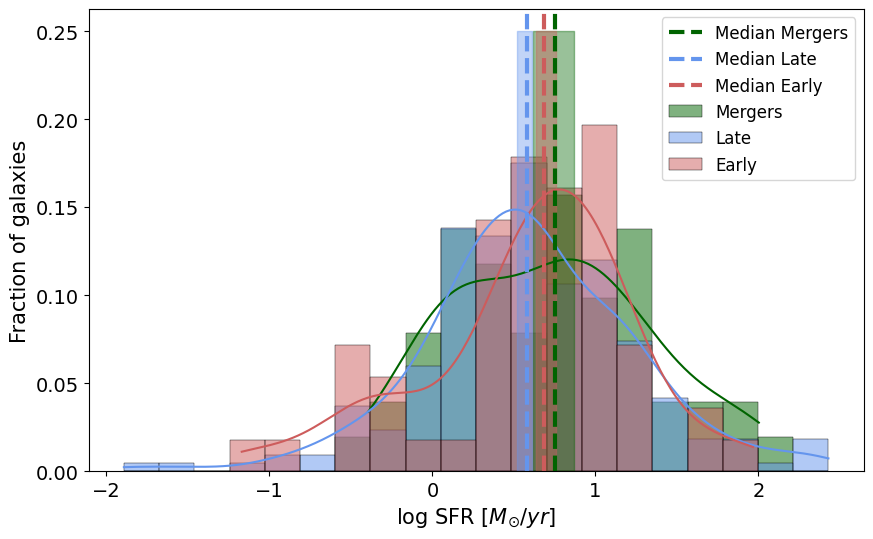

In [29]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

sfr_mergers = merger_galaxies['logSFR_NUV']
sfr_late = late_galaxies['logSFR_NUV']
sfr_early = early_galaxies['logSFR_NUV']
# Crear bins
bin_edges = np.linspace(min(sfr_mergers.min(), sfr_late.min(), sfr_early.min()), 
                        max(sfr_mergers.max(), sfr_late.max(), sfr_early.max()), 
                        21)
# Ejemplo de uso para tus distribuciones
median_mergers, err_low_mergers, err_high_mergers = bootstrap_median_error(sfr_mergers)
median_late, err_low_late, err_high_late = bootstrap_median_error(sfr_late)
median_early, err_low_early, err_high_early = bootstrap_median_error(sfr_early)

# Imprimir resultados
print(f"Mergers Median: {median_mergers:.2f} (+{err_high_mergers:.2f} / -{err_low_mergers:.2f})")
print(f"Late Median: {median_late:.2f} (+{err_high_late:.2f} / -{err_low_late:.2f})")
print(f"Early Median: {median_early:.2f} (+{err_high_early:.2f} / -{err_low_early:.2f})")


# Crear la figura
plt.figure(figsize=(10, 6))

# Histogramas
sns.histplot(sfr_mergers, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='darkgreen', label='Mergers', edgecolor='black', linewidth=0.3)
sns.histplot(sfr_late, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='cornflowerblue', label='Late', edgecolor='black', linewidth=0.3)
sns.histplot(sfr_early, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='indianred', label='Early', edgecolor='black', linewidth=0.3)

plt.axvline(median_mergers, color='darkgreen', linestyle='--', linewidth=3, label='Median Mergers')
plt.fill_betweenx(y=[0, 0.25], x1=median_mergers - err_low_mergers, x2=median_mergers + err_high_mergers, 
                  color='darkgreen', alpha=0.4)
plt.axvline(median_late, color='cornflowerblue', linestyle='--', linewidth=3, label='Median Late')
plt.fill_betweenx(y=[0, 0.25], x1=median_late - err_low_late, x2=median_late + err_high_late, 
                  color='cornflowerblue', alpha=0.4)
plt.axvline(median_early, color='indianred', linestyle='--', linewidth=3, label='Median Early')
plt.fill_betweenx(y=[0, 0.25], x1=median_early - err_low_early, x2=median_early + err_high_early, 
                  color='indianred', alpha=0.4)

# Etiquetas y título
plt.xlabel('log SFR $[M_{\odot}/yr]$', fontsize=15)
plt.ylabel('Fraction of galaxies', fontsize=15)
plt.xticks(size=14)
plt.yticks(size=14)

# Leyenda
plt.legend(fontsize=12)

# Mostrar gráfico
plt.show()

Mergers Median in SFCGs: 0.75 (+0.11 / -0.08)
Mergers Median in the Field: 0.01 (+0.13 / -0.13)


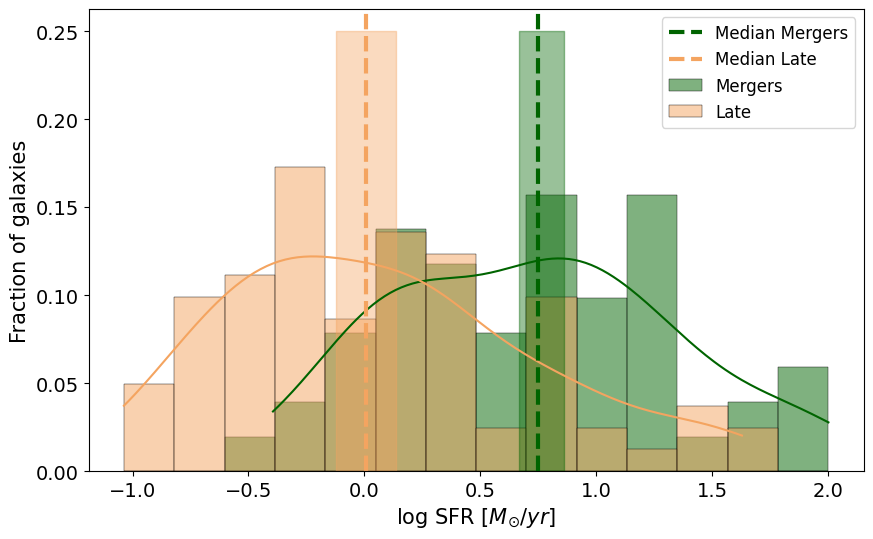

In [30]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

sfr_mergers = merger_galaxies['logSFR_NUV']
sfr_mergers_cs = merger_galaxies_cs['logSFR_NUV']
# Crear bins
bin_edges = np.linspace(min(sfr_mergers.min(), sfr_mergers_cs.min()), 
                        max(sfr_mergers.max(), sfr_mergers_cs.max()), 
                        15)
# Ejemplo de uso para tus distribuciones
median_mergers, err_low_mergers, err_high_mergers = bootstrap_median_error(sfr_mergers)
median_mergers_cs, err_low_mergers_cs, err_high_mergers_cs = bootstrap_median_error(sfr_mergers_cs)

# Imprimir resultados
print(f"Mergers Median in SFCGs: {median_mergers:.2f} (+{err_high_mergers:.2f} / -{err_low_mergers:.2f})")
print(f"Mergers Median in the Field: {median_mergers_cs:.2f} (+{err_high_mergers_cs:.2f} / -{err_low_mergers_cs:.2f})")


# Crear la figura
plt.figure(figsize=(10, 6))

# Histogramas
sns.histplot(sfr_mergers, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='darkgreen', label='Mergers', edgecolor='black', linewidth=0.3)
sns.histplot(sfr_mergers_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='sandybrown', label='Late', edgecolor='black', linewidth=0.3)

plt.axvline(median_mergers, color='darkgreen', linestyle='--', linewidth=3, label='Median Mergers')
plt.fill_betweenx(y=[0, 0.25], x1=median_mergers - err_low_mergers, x2=median_mergers + err_high_mergers, 
                  color='darkgreen', alpha=0.4)
plt.axvline(median_mergers_cs, color='sandybrown', linestyle='--', linewidth=3, label='Median Late')
plt.fill_betweenx(y=[0, 0.25], x1=median_mergers_cs - err_low_mergers_cs, x2=median_mergers_cs + err_high_mergers_cs, 
                  color='sandybrown', alpha=0.4)


# Etiquetas y título
plt.xlabel('log SFR $[M_{\odot}/yr]$', fontsize=15)
plt.ylabel('Fraction of galaxies', fontsize=15)
plt.xticks(size=14)
plt.yticks(size=14)

# Leyenda
plt.legend(fontsize=12)

# Mostrar gráfico
plt.show()

Late Median in SFCGs: 0.58 (+0.03 / -0.04)
Late Median in the Field: 0.26 (+0.03 / -0.02)


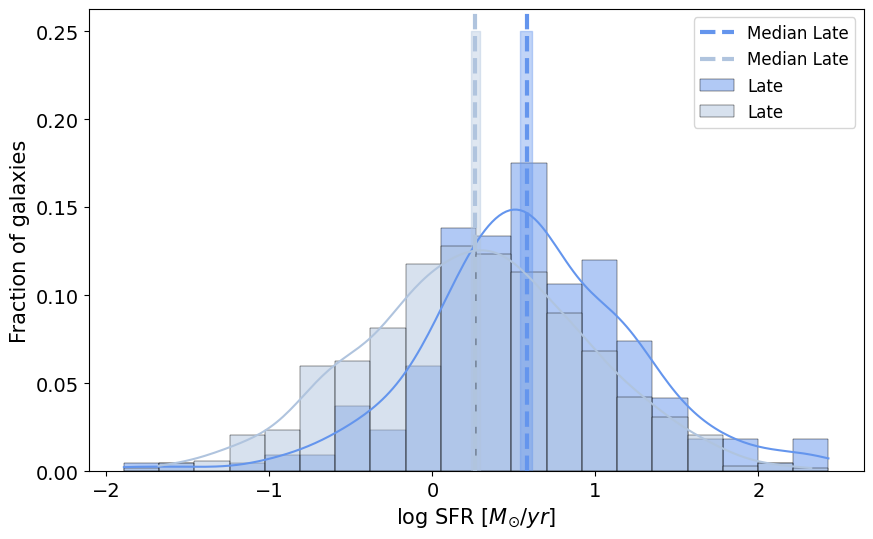

In [31]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

sfr_late = late_galaxies['logSFR_NUV']
sfr_late_cs = late_galaxies_cs['logSFR_NUV']
# Crear bins
bin_edges = np.linspace(min(sfr_late.min(), sfr_late_cs.min()), 
                        max(sfr_late.max(), sfr_late_cs.max()), 
                        21)
# Ejemplo de uso para tus distribuciones
median_late, err_low_late, err_high_late = bootstrap_median_error(sfr_late)
median_late_cs, err_low_late_cs, err_high_late_cs = bootstrap_median_error(sfr_late_cs)

# Imprimir resultados
print(f"Late Median in SFCGs: {median_late:.2f} (+{err_high_late:.2f} / -{err_low_late:.2f})")
print(f"Late Median in the Field: {median_late_cs:.2f} (+{err_high_late_cs:.2f} / -{err_low_late_cs:.2f})")


# Crear la figura
plt.figure(figsize=(10, 6))

# Histogramas
sns.histplot(sfr_late, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='cornflowerblue', label='Late', edgecolor='black', linewidth=0.3)
sns.histplot(sfr_late_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='lightsteelblue', label='Late', edgecolor='black', linewidth=0.3)

plt.axvline(median_late, color='cornflowerblue', linestyle='--', linewidth=3, label='Median Late')
plt.fill_betweenx(y=[0, 0.25], x1=median_late - err_low_late, x2=median_late + err_high_late, 
                  color='cornflowerblue', alpha=0.4)
plt.axvline(median_late_cs, color='lightsteelblue', linestyle='--', linewidth=3, label='Median Late')
plt.fill_betweenx(y=[0, 0.25], x1=median_late_cs - err_low_late_cs, x2=median_late_cs + err_high_late_cs, 
                  color='lightsteelblue', alpha=0.4)


# Etiquetas y título
plt.xlabel('log SFR $[M_{\odot}/yr]$', fontsize=15)
plt.ylabel('Fraction of galaxies', fontsize=15)
plt.xticks(size=14)
plt.yticks(size=14)

# Leyenda
plt.legend(fontsize=12)

# Mostrar gráfico
plt.show()

early Median in SFCGs: 0.68 (+0.07 / -0.05)
early Median in the Field: 0.15 (+0.06 / -0.08)


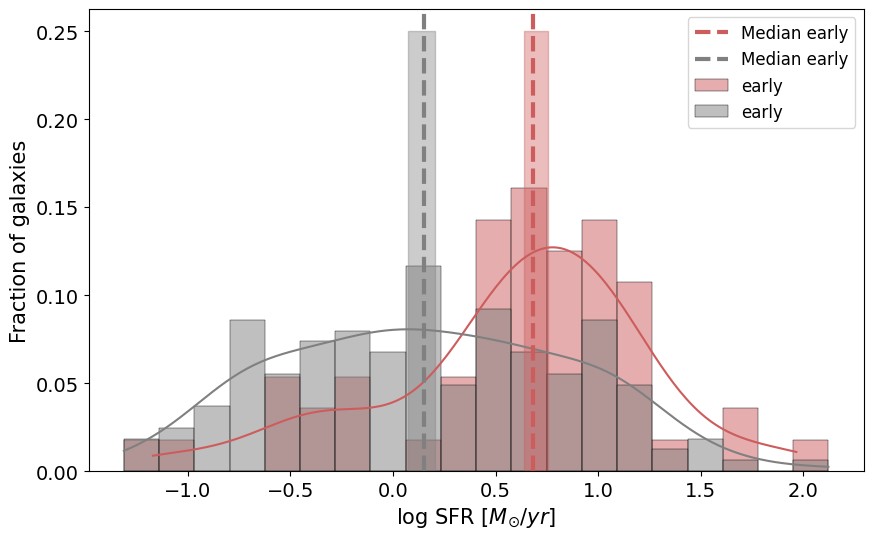

In [32]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

sfr_early = early_galaxies['logSFR_NUV']
sfr_early_cs = early_galaxies_cs['logSFR_NUV']
# Crear bins
bin_edges = np.linspace(min(sfr_early.min(), sfr_early_cs.min()), 
                        max(sfr_early.max(), sfr_early_cs.max()), 
                        21)
# Ejemplo de uso para tus distribuciones
median_early, err_low_early, err_high_early = bootstrap_median_error(sfr_early)
median_early_cs, err_low_early_cs, err_high_early_cs = bootstrap_median_error(sfr_early_cs)

# Imprimir resultados
print(f"early Median in SFCGs: {median_early:.2f} (+{err_high_early:.2f} / -{err_low_early:.2f})")
print(f"early Median in the Field: {median_early_cs:.2f} (+{err_high_early_cs:.2f} / -{err_low_early_cs:.2f})")


# Crear la figura
plt.figure(figsize=(10, 6))

# Histogramas
sns.histplot(sfr_early, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='indianred', label='early', edgecolor='black', linewidth=0.3)
sns.histplot(sfr_early_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='grey', label='early', edgecolor='black', linewidth=0.3)

plt.axvline(median_early, color='indianred', linestyle='--', linewidth=3, label='Median early')
plt.fill_betweenx(y=[0, 0.25], x1=median_early - err_low_early, x2=median_early + err_high_early, 
                  color='indianred', alpha=0.4)
plt.axvline(median_early_cs, color='grey', linestyle='--', linewidth=3, label='Median early')
plt.fill_betweenx(y=[0, 0.25], x1=median_early_cs - err_low_early_cs, x2=median_early_cs + err_high_early_cs, 
                  color='grey', alpha=0.4)


# Etiquetas y título
plt.xlabel('log SFR $[M_{\odot}/yr]$', fontsize=15)
plt.ylabel('Fraction of galaxies', fontsize=15)
plt.xticks(size=14)
plt.yticks(size=14)

# Leyenda
plt.legend(fontsize=12)

# Mostrar gráfico
plt.show()

Mergers Median: 0.01 (+0.10 / -0.14)
Late Median: 0.26 (+0.03 / -0.02)
Early Median: 0.15 (+0.06 / -0.07)


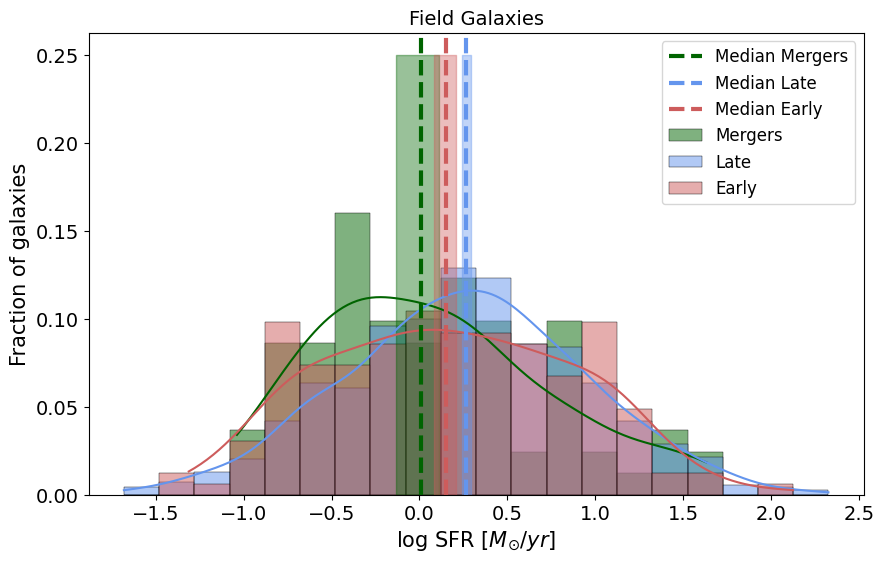

In [33]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

sfr_mergers = merger_galaxies_cs['logSFR_NUV']
sfr_late = late_galaxies_cs['logSFR_NUV']
sfr_early = early_galaxies_cs['logSFR_NUV']
# Crear bins
bin_edges = np.linspace(min(sfr_mergers.min(), sfr_late.min(), sfr_early.min()), 
                        max(sfr_mergers.max(), sfr_late.max(), sfr_early.max()), 
                        21)
# Ejemplo de uso para tus distribuciones
median_mergers, err_low_mergers, err_high_mergers = bootstrap_median_error(sfr_mergers)
median_late, err_low_late, err_high_late = bootstrap_median_error(sfr_late)
median_early, err_low_early, err_high_early = bootstrap_median_error(sfr_early)

# Imprimir resultados
print(f"Mergers Median: {median_mergers:.2f} (+{err_high_mergers:.2f} / -{err_low_mergers:.2f})")
print(f"Late Median: {median_late:.2f} (+{err_high_late:.2f} / -{err_low_late:.2f})")
print(f"Early Median: {median_early:.2f} (+{err_high_early:.2f} / -{err_low_early:.2f})")


# Crear la figura
plt.figure(figsize=(10, 6))

# Histogramas
sns.histplot(sfr_mergers, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='darkgreen', label='Mergers', edgecolor='black', linewidth=0.3)
sns.histplot(sfr_late, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='cornflowerblue', label='Late', edgecolor='black', linewidth=0.3)
sns.histplot(sfr_early, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='indianred', label='Early', edgecolor='black', linewidth=0.3)

plt.axvline(median_mergers, color='darkgreen', linestyle='--', linewidth=3, label='Median Mergers')
plt.fill_betweenx(y=[0, 0.25], x1=median_mergers - err_low_mergers, x2=median_mergers + err_high_mergers, 
                  color='darkgreen', alpha=0.4)
plt.axvline(median_late, color='cornflowerblue', linestyle='--', linewidth=3, label='Median Late')
plt.fill_betweenx(y=[0, 0.25], x1=median_late - err_low_late, x2=median_late + err_high_late, 
                  color='cornflowerblue', alpha=0.4)
plt.axvline(median_early, color='indianred', linestyle='--', linewidth=3, label='Median Early')
plt.fill_betweenx(y=[0, 0.25], x1=median_early - err_low_early, x2=median_early + err_high_early, 
                  color='indianred', alpha=0.4)

# Etiquetas y título
plt.xlabel('log SFR $[M_{\odot}/yr]$', fontsize=15)
plt.ylabel('Fraction of galaxies', fontsize=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Field Galaxies', fontsize=14)
# Leyenda
plt.legend(fontsize=12)

# Mostrar gráfico
plt.show()

Mergers Median: -9.00 (+0.08 / -0.23)
Late Median: -9.20 (+0.04 / -0.06)
Early Median: -9.63 (+0.06 / -0.02)


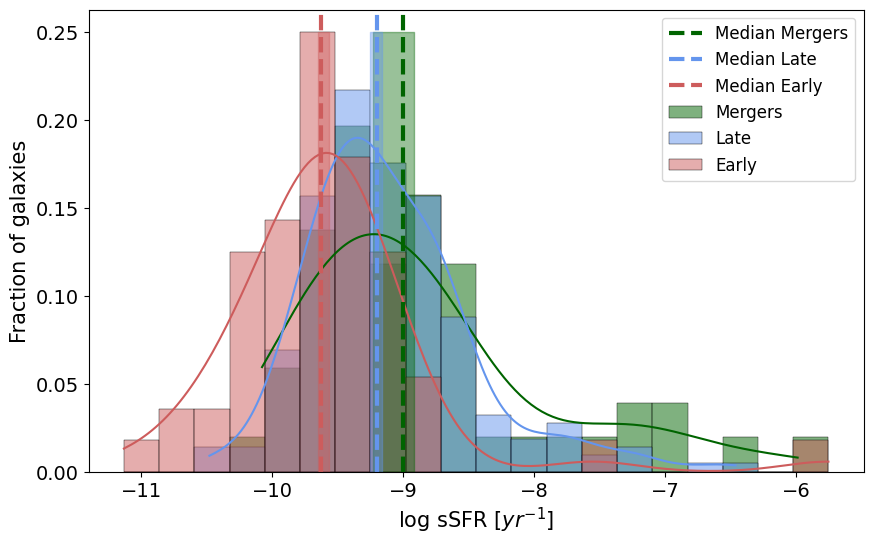

In [34]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

ssfr_mergers = merger_galaxies['log_sSFR']
ssfr_late = late_galaxies['log_sSFR']
ssfr_early = early_galaxies['log_sSFR']
# Crear bins
bin_edges = np.linspace(min(ssfr_mergers.min(), ssfr_late.min(), ssfr_early.min()), 
                        max(ssfr_mergers.max(), ssfr_late.max(), ssfr_early.max()), 
                        21)
# Ejemplo de uso para tus distribuciones
median_mergers, err_low_mergers, err_high_mergers = bootstrap_median_error(ssfr_mergers)
median_late, err_low_late, err_high_late = bootstrap_median_error(ssfr_late)
median_early, err_low_early, err_high_early = bootstrap_median_error(ssfr_early)

# Imprimir resultados
print(f"Mergers Median: {median_mergers:.2f} (+{err_high_mergers:.2f} / -{err_low_mergers:.2f})")
print(f"Late Median: {median_late:.2f} (+{err_high_late:.2f} / -{err_low_late:.2f})")
print(f"Early Median: {median_early:.2f} (+{err_high_early:.2f} / -{err_low_early:.2f})")


# Crear la figura
plt.figure(figsize=(10, 6))

# Histogramas
sns.histplot(ssfr_mergers, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='darkgreen', label='Mergers', edgecolor='black', linewidth=0.3)
sns.histplot(ssfr_late, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='cornflowerblue', label='Late', edgecolor='black', linewidth=0.3)
sns.histplot(ssfr_early, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='indianred', label='Early', edgecolor='black', linewidth=0.3)

plt.axvline(median_mergers, color='darkgreen', linestyle='--', linewidth=3, label='Median Mergers')
plt.fill_betweenx(y=[0, 0.25], x1=median_mergers - err_low_mergers, x2=median_mergers + err_high_mergers, 
                  color='darkgreen', alpha=0.4)
plt.axvline(median_late, color='cornflowerblue', linestyle='--', linewidth=3, label='Median Late')
plt.fill_betweenx(y=[0, 0.25], x1=median_late - err_low_late, x2=median_late + err_high_late, 
                  color='cornflowerblue', alpha=0.4)
plt.axvline(median_early, color='indianred', linestyle='--', linewidth=3, label='Median Early')
plt.fill_betweenx(y=[0, 0.25], x1=median_early - err_low_early, x2=median_early + err_high_early, 
                  color='indianred', alpha=0.4)

# Etiquetas y título
plt.xlabel('log sSFR $[yr^{-1}]$', fontsize=15)
plt.ylabel('Fraction of galaxies', fontsize=15)
plt.xticks(size=14)
plt.yticks(size=14)

# Leyenda
plt.legend(fontsize=12)

# Mostrar gráfico
plt.show()

Mergers Median: -9.47 (+0.06 / -0.03)
Late Median: -9.52 (+0.02 / -0.02)
Early Median: -10.13 (+0.09 / -0.07)


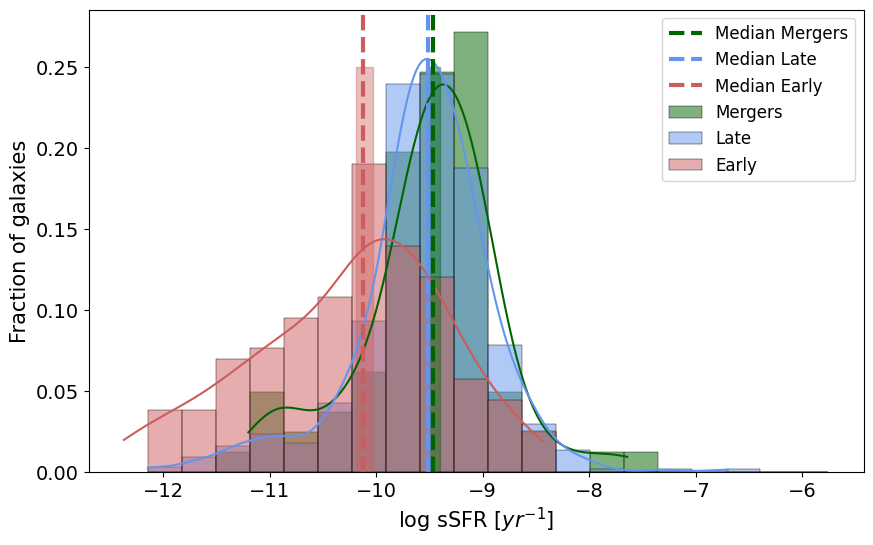

In [35]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

ssfr_mergers_cs = merger_galaxies_cs['log_sSFR']
ssfr_late_cs = late_galaxies_cs['log_sSFR']
ssfr_early_cs = early_galaxies_cs['log_sSFR']
# Crear bins
bin_edges = np.linspace(min(ssfr_mergers_cs.min(), ssfr_late_cs.min(), ssfr_early.min()), 
                        max(ssfr_mergers_cs.max(), ssfr_late_cs.max(), ssfr_early.max()), 
                        21)
# Ejemplo de uso para tus distribuciones
median_mergers, err_low_mergers, err_high_mergers = bootstrap_median_error(ssfr_mergers_cs)
median_late, err_low_late, err_high_late = bootstrap_median_error(ssfr_late_cs)
median_early, err_low_early, err_high_early = bootstrap_median_error(ssfr_early_cs)

# Imprimir resultados
print(f"Mergers Median: {median_mergers:.2f} (+{err_high_mergers:.2f} / -{err_low_mergers:.2f})")
print(f"Late Median: {median_late:.2f} (+{err_high_late:.2f} / -{err_low_late:.2f})")
print(f"Early Median: {median_early:.2f} (+{err_high_early:.2f} / -{err_low_early:.2f})")


# Crear la figura
plt.figure(figsize=(10, 6))

# Histogramas
sns.histplot(ssfr_mergers_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='darkgreen', label='Mergers', edgecolor='black', linewidth=0.3)
sns.histplot(ssfr_late_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='cornflowerblue', label='Late', edgecolor='black', linewidth=0.3)
sns.histplot(ssfr_early_cs, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='indianred', label='Early', edgecolor='black', linewidth=0.3)

plt.axvline(median_mergers, color='darkgreen', linestyle='--', linewidth=3, label='Median Mergers')
plt.fill_betweenx(y=[0, 0.25], x1=median_mergers - err_low_mergers, x2=median_mergers + err_high_mergers, 
                  color='darkgreen', alpha=0.4)
plt.axvline(median_late, color='cornflowerblue', linestyle='--', linewidth=3, label='Median Late')
plt.fill_betweenx(y=[0, 0.25], x1=median_late - err_low_late, x2=median_late + err_high_late, 
                  color='cornflowerblue', alpha=0.4)
plt.axvline(median_early, color='indianred', linestyle='--', linewidth=3, label='Median Early')
plt.fill_betweenx(y=[0, 0.25], x1=median_early - err_low_early, x2=median_early + err_high_early, 
                  color='indianred', alpha=0.4)

# Etiquetas y título
plt.xlabel('log sSFR $[yr^{-1}]$', fontsize=15)
plt.ylabel('Fraction of galaxies', fontsize=15)
plt.xticks(size=14)
plt.yticks(size=14)

# Leyenda
plt.legend(fontsize=12)

# Mostrar gráfico
plt.show()

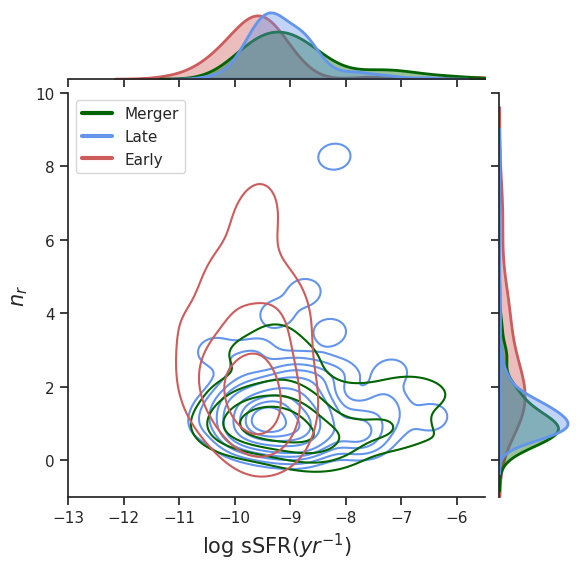

In [36]:
from matplotlib.lines import Line2D

# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Merger': 'darkgreen', 'Late': 'cornflowerblue', 'Early' : 'indianred'}


sur = sfr_decals['Tipo']

# Lista de columnas que quieres graficar
x = sfr_decals['log_sSFR']
y = sfr_decals['n_r']
# Crear la figura
g = sns.JointGrid(data=sfr_decals, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(-13, -5.5)
g.ax_joint.set_ylim(-1, 10)
# Añadir títulos
g.set_axis_labels("log sSFR($yr^{-1}$)", f"$n_r$", fontsize=15)

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

#g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()

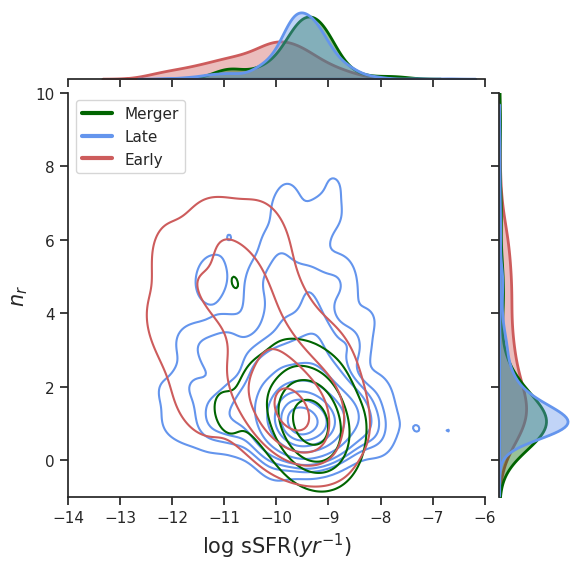

In [37]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Merger': 'darkgreen', 'Late': 'cornflowerblue', 'Early' : 'indianred'}


sur = sfr_cs['Tipo']

# Lista de columnas que quieres graficar
x = sfr_cs['log_sSFR']
y = sfr_cs['n_r']
# Crear la figura
g = sns.JointGrid(data=sfr_cs, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(-14, -6)
g.ax_joint.set_ylim(-1, 10)
# Añadir títulos
g.set_axis_labels("log sSFR($yr^{-1}$)", f"$n_r$", fontsize=15)

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

#g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()

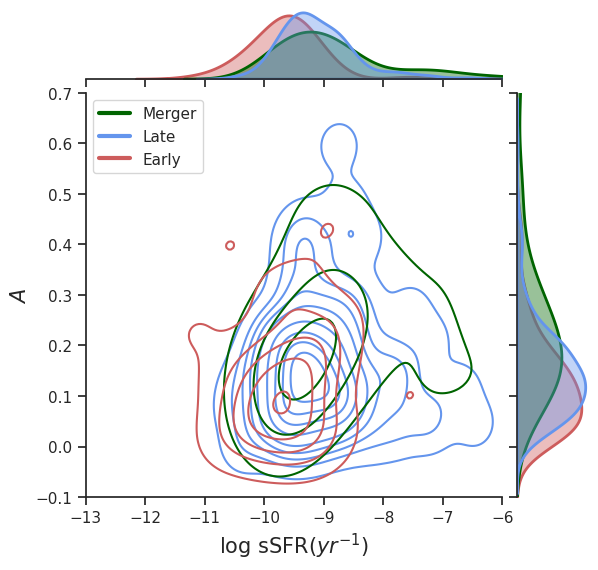

In [50]:
from matplotlib.lines import Line2D

# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Merger': 'darkgreen', 'Late': 'cornflowerblue', 'Early' : 'indianred'}


sur = sfr_decals['Tipo']

# Lista de columnas que quieres graficar
x = sfr_decals['log_sSFR']
y = sfr_decals['A']
# Crear la figura
g = sns.JointGrid(data=sfr_decals, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(-13, -6)
g.ax_joint.set_ylim(-0.1, .7)
# Añadir títulos
g.set_axis_labels("log sSFR($yr^{-1}$)", f"$A$", fontsize=15)

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

#g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()

Mergers Median: 0.20 (+0.01 / -0.02)
Late Median: 0.13 (+0.01 / -0.00)
Early Median: 0.11 (+0.01 / -0.01)


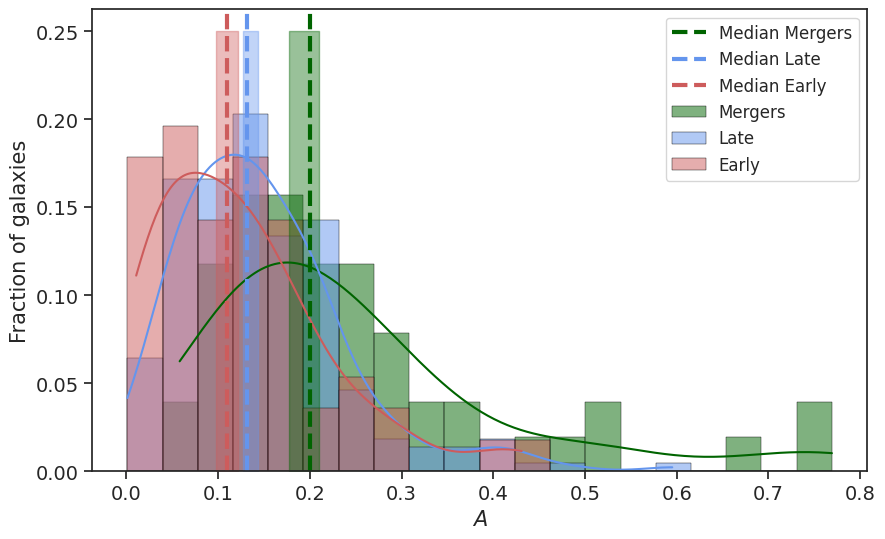

In [39]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

assymetry_mergers = merger_galaxies['A']
assymetry_late = late_galaxies['A']
assymetry_early = early_galaxies['A']
# Crear bins
bin_edges = np.linspace(min(assymetry_mergers.min(), assymetry_late.min()),# ssfr_early.min()), 
                        max(assymetry_mergers.max(), assymetry_late.max()),# ssfr_early.max()), 
                        21)
# Ejemplo de uso para tus distribuciones
median_mergers, err_low_mergers, err_high_mergers = bootstrap_median_error(assymetry_mergers)
median_late, err_low_late, err_high_late = bootstrap_median_error(assymetry_late)
median_early, err_low_early, err_high_early = bootstrap_median_error(assymetry_early)

# Imprimir resultados
print(f"Mergers Median: {median_mergers:.2f} (+{err_high_mergers:.2f} / -{err_low_mergers:.2f})")
print(f"Late Median: {median_late:.2f} (+{err_high_late:.2f} / -{err_low_late:.2f})")
print(f"Early Median: {median_early:.2f} (+{err_high_early:.2f} / -{err_low_early:.2f})")


# Crear la figura
plt.figure(figsize=(10, 6))

# Histogramas
sns.histplot(assymetry_mergers, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='darkgreen', label='Mergers', edgecolor='black', linewidth=0.3)
sns.histplot(assymetry_late, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='cornflowerblue', label='Late', edgecolor='black', linewidth=0.3)
sns.histplot(assymetry_early, kde=True, stat='probability', alpha=0.5, bins=bin_edges, 
             color='indianred', label='Early', edgecolor='black', linewidth=0.3)

plt.axvline(median_mergers, color='darkgreen', linestyle='--', linewidth=3, label='Median Mergers')
plt.fill_betweenx(y=[0, 0.25], x1=median_mergers - err_low_mergers, x2=median_mergers + err_high_mergers, 
                  color='darkgreen', alpha=0.4)
plt.axvline(median_late, color='cornflowerblue', linestyle='--', linewidth=3, label='Median Late')
plt.fill_betweenx(y=[0, 0.25], x1=median_late - err_low_late, x2=median_late + err_high_late, 
                  color='cornflowerblue', alpha=0.4)
plt.axvline(median_early, color='indianred', linestyle='--', linewidth=3, label='Median Early')
plt.fill_betweenx(y=[0, 0.25], x1=median_early - err_low_early, x2=median_early + err_high_early, 
                  color='indianred', alpha=0.4)

# Etiquetas y título
plt.xlabel('$A$', fontsize=15)
plt.ylabel('Fraction of galaxies', fontsize=15)
plt.xticks(size=14)
plt.yticks(size=14)

# Leyenda
plt.legend(fontsize=12)

# Mostrar gráfico
plt.show()

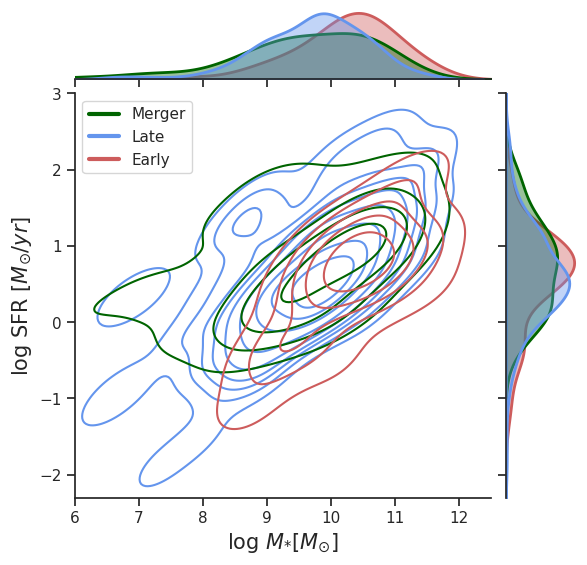

In [40]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Merger': 'darkgreen', 'Late': 'cornflowerblue', 'Early' : 'indianred'}


sur = sfr_decals['Tipo']

# Lista de columnas que quieres graficar
x = sfr_decals['stellar_mass_phot_i']
y = sfr_decals['logSFR_NUV']
# Crear la figura
g = sns.JointGrid(data=sfr_decals, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(6, 12.5)
g.ax_joint.set_ylim(-2.3, 3)
# Añadir títulos
g.set_axis_labels("log $M_{*}[M_{\odot}]$", "log SFR $[M_{\odot}/yr]$", fontsize=15)

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

#g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()

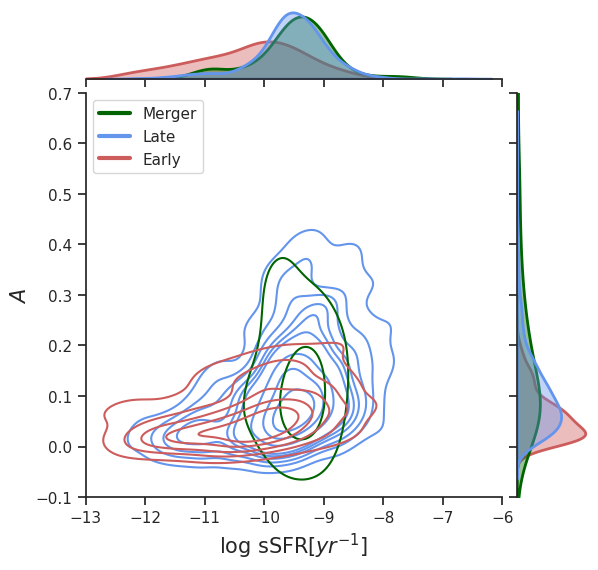

In [41]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Merger': 'darkgreen', 'Late': 'cornflowerblue', 'Early' : 'indianred'}


sur = sfr_cs['Tipo']

# Lista de columnas que quieres graficar
x = sfr_cs['log_sSFR']
y = sfr_cs['A']
# Crear la figura
g = sns.JointGrid(data=sfr_cs, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(-13, -6)
g.ax_joint.set_ylim(-0.1, 0.7)
# Añadir títulos
g.set_axis_labels("log sSFR[$yr^{-1}$]", f"$A$", fontsize=15)

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

#g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()

In [42]:
type_column = Column(['SFCG Galaxy'] * len(sfr_decals), name='Nature')
sfr_decals.add_column(type_column)

type_column_cs = Column(['Field Galaxy'] * len(sfr_cs), name='Nature')
sfr_cs.add_column(type_column_cs)

sfr_decals_columns = sfr_decals['Gini', 'M20', 'A', 'C', 'log_sSFR', 'logSFR_NUV', 'stellar_mass_phot_i', 'Tipo', 'Nature']
sfr_cs_columns = sfr_cs['Gini', 'M20', 'A', 'C', 'log_sSFR', 'logSFR_NUV', 'stellar_mass_phot_i', 'Tipo', 'Nature']

cg_cs = vstack([sfr_decals_columns, sfr_cs_columns])

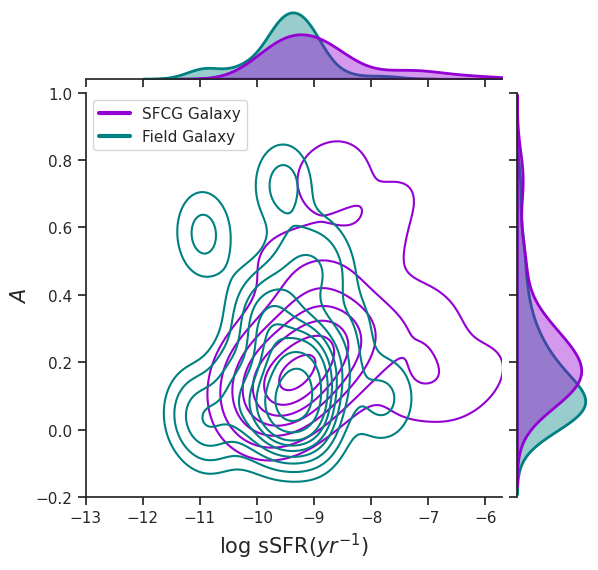

In [43]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'SFCG Galaxy': 'darkviolet', 'Field Galaxy': 'teal'}

data = cg_cs[cg_cs['Tipo'] == 'Merger']
sur = data['Nature']
# Lista de columnas que quieres graficar
x = data['log_sSFR']
y = data['A']
# Crear la figura
g = sns.JointGrid(data=data, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(-13, -5.7)
g.ax_joint.set_ylim(-0.2, 1)
# Añadir títulos
g.set_axis_labels("log sSFR($yr^{-1}$)", f"$A$", fontsize=15)

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

#g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()

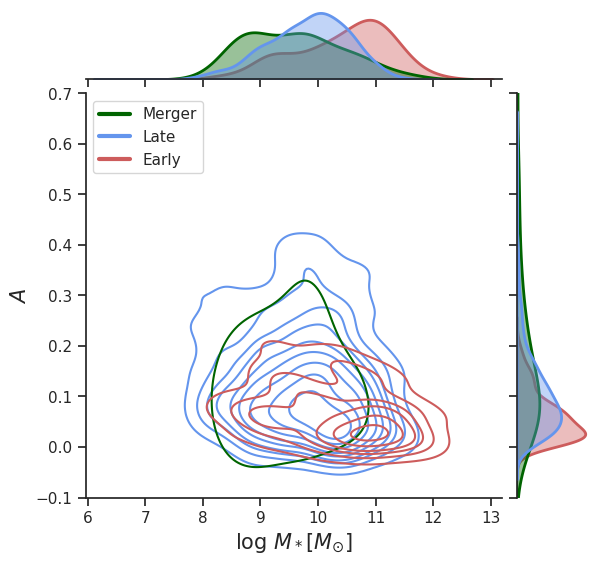

In [44]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Merger': 'darkgreen', 'Late': 'cornflowerblue', 'Early' : 'indianred'}


sur = sfr_cs['Tipo']

# Lista de columnas que quieres graficar
x = sfr_cs['stellar_mass_phot_i']
y = sfr_cs['A']
# Crear la figura
g = sns.JointGrid(data=sfr_cs, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
#g.ax_joint.set_xlim(-13, -6)
g.ax_joint.set_ylim(-0.1, 0.7)
# Añadir títulos
g.set_axis_labels("log $M_*[M_{\odot}$]", f"$A$", fontsize=15)

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

#g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()

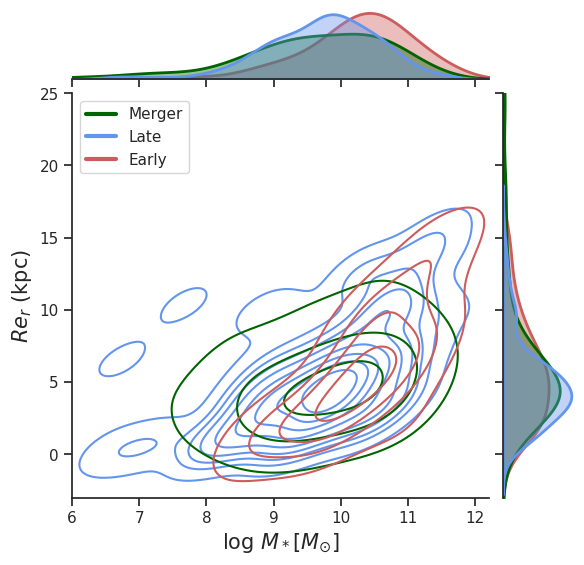

In [45]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Merger': 'darkgreen', 'Late': 'cornflowerblue', 'Early' : 'indianred'}
sfr_decals_2 = sfr_decals[(sfr_decals['RE_r(kpc)']<100) & (sfr_decals['RE_r(kpc)']!=0.0)]

sur = sfr_decals_2['Tipo']

# Lista de columnas que quieres graficar
x = sfr_decals_2['stellar_mass_phot_i']
y = sfr_decals_2['RE_r(kpc)']
# Crear la figura
g = sns.JointGrid(data=sfr_decals_2, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(6, 12.2)
g.ax_joint.set_ylim(-3, 25)
# Añadir títulos
g.set_axis_labels("log $M_*[M_{\odot}$]", f"$Re_r$ (kpc)", fontsize=15)

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

#g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()

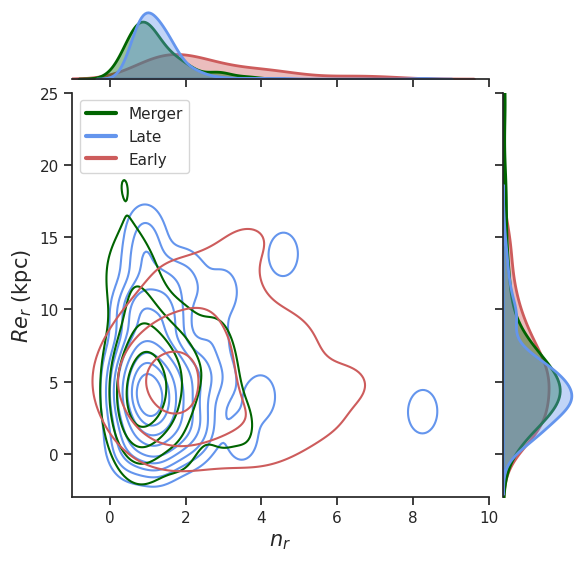

In [46]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Merger': 'darkgreen', 'Late': 'cornflowerblue', 'Early' : 'indianred'}
sfr_decals_2 = sfr_decals[(sfr_decals['RE_r(kpc)']<100) & (sfr_decals['RE_r(kpc)']!=0.0)]

sur = sfr_decals_2['Tipo']

# Lista de columnas que quieres graficar
x = sfr_decals_2['n_r']
y = sfr_decals_2['RE_r(kpc)']
# Crear la figura
g = sns.JointGrid(data=sfr_decals_2, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(-1, 10)
g.ax_joint.set_ylim(-3, 25)
# Añadir títulos
g.set_axis_labels("$n_r$", f"$Re_r$ (kpc)", fontsize=15)

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

#g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()

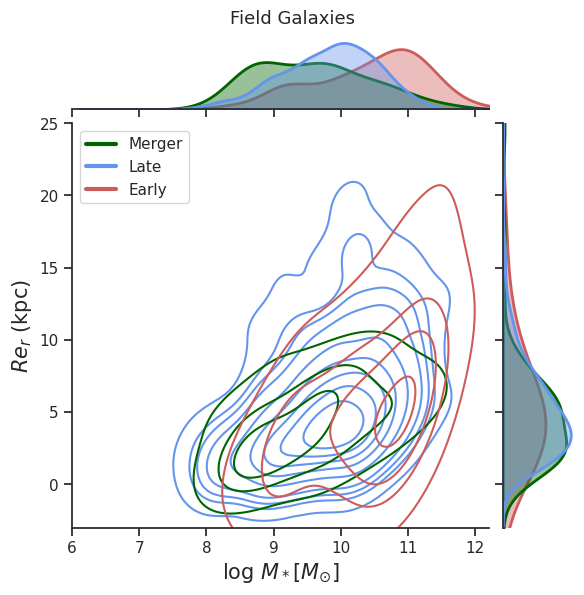

In [47]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Merger': 'darkgreen', 'Late': 'cornflowerblue', 'Early' : 'indianred'}
sfr_cs = sfr_cs[(sfr_cs['RE_r(kpc)']<100) & (sfr_cs['RE_r(kpc)']!=0.0) & (sfr_cs['RE_r(kpc)']>0)]

sur = sfr_cs['Tipo']

# Lista de columnas que quieres graficar
x = sfr_cs['stellar_mass_phot_i']
y = sfr_cs['RE_r(kpc)']
# Crear la figura
g = sns.JointGrid(data=sfr_cs, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(6, 12.2)
g.ax_joint.set_ylim(-3, 25)
# Añadir títulos
g.set_axis_labels("log $M_*[M_{\odot}$]", f"$Re_r$ (kpc)", fontsize=15)
g.fig.suptitle('Field Galaxies', fontsize=13)
# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper left")

#g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()

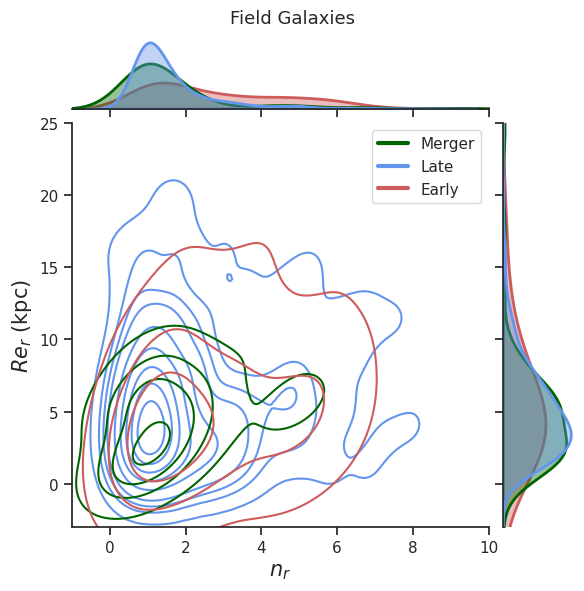

In [48]:
# Ignorar los warnings
warnings.filterwarnings("ignore")

# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'Merger': 'darkgreen', 'Late': 'cornflowerblue', 'Early' : 'indianred'}
sfr_cs = sfr_cs[(sfr_cs['RE_r(kpc)']<100) & (sfr_cs['RE_r(kpc)']!=0.0) & (sfr_cs['RE_r(kpc)']>0)]

sur = sfr_cs['Tipo']

# Lista de columnas que quieres graficar
x = sfr_cs['n_r']
y = sfr_cs['RE_r(kpc)']
# Crear la figura
g = sns.JointGrid(data=sfr_cs, x=x, y=y, hue=sur, palette=custom_palette, height=6)
    
# Gráficos principales: KDE con efecto desvanecido
g.plot_joint(
    sns.kdeplot,
    fill=False,
    alpha=1,
    linewidth=0,  # Contornos suaves
    )
    
# Gráficos marginales: KDE relleno
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    common_norm=False,
    alpha=0.4,  # Transparencia
    linewidth=2  # Sin bordes
)
# Limitar los ejes
g.ax_joint.set_xlim(-1, 10)
g.ax_joint.set_ylim(-3, 25)
# Añadir títulos
g.set_axis_labels("$n_r$", f"$Re_r$ (kpc)", fontsize=15)
g.fig.suptitle('Field Galaxies', fontsize=13)

# Crear handles y labels para la leyenda
handles = [Line2D([0], [0], color=custom_palette[name], lw=3) for name in custom_palette]
labels = list(custom_palette.keys())

# Añadir la leyenda
g.ax_joint.legend(handles=handles, labels=labels, loc="upper right")

#g.fig.suptitle(f"Late Type Galaxies", fontsize=14)  # Título principal
g.fig.subplots_adjust(top=0.93)  # Ajustar para que el título no se superponga
# Mostrar el gráfico
plt.show()